In [75]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
pwd

'd:\\소셜네트워크과학\\Drug_Coprescription_Network_Analysis'

In [ ]:
cd D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis

D:\소셜네트워크과학\Drug_Coprescription_Network_Analysis


C:\Users\alexj\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!git pull

fatal: unable to access 'https://github.com/YuHan-J-Nam/Drug_Coprescription_Network_Analysis.git/': Could not resolve host: github.com


### 데이터 추출
항우울제로 사용되는 약물들만 추출하도록 하겠습니다.

In [26]:
# 데이터의 구조를 확인합니다.
data = pd.read_csv('D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_01_20211231.csv', encoding='cp949', nrows=5)
data

,STND_Y,IDV_ID,KEY_SEQ,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,GNL_NM_CD,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,628074,9261,1,2,13,41,2021-09-13,347701ACH,1.0,1,3,521.0,1563,2022-08-11
1,2021,730013,13348,1,2,13,41,2021-02-17,493801ATB,1.0,1,3,534.0,1602,2022-08-11
2,2021,97734,16827,1,2,13,41,2021-06-10,374602ATB,1.0,1,3,469.0,1407,2022-08-11
3,2021,818851,20079,1,2,13,41,2021-09-15,367201ATB,1.0,1,3,764.0,2292,2022-08-11
4,2021,835362,26258,1,2,13,41,2021-07-17,111501ATB,1.0,1,30,644.0,19320,2022-08-11


In [28]:
# 주성분코드 리스트를 읽어옵니다.
with open('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/antidepressant_MI_code.txt', 'r') as f:
    ingredient_code = f.read().splitlines()

In [29]:
# 전체 파일에서 주성분코드 리스트에 있는 주성분코드가 포함된 행만 추출합니다.
rows = []
for chunk in pd.read_csv('D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_01_20211231.csv', encoding='cp949', chunksize=100000):
    rows.append(chunk[chunk['GNL_NM_CD'].isin(ingredient_code)])
for chunk in pd.read_csv('D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_02_20211231.csv', encoding='cp949', chunksize=100000):
    rows.append(chunk[chunk['GNL_NM_CD'].isin(ingredient_code)])
for chunk in pd.read_csv('D:/소셜네트워크과학/국민건강보험공단_의약품처방정보_03_20211231.csv', encoding='cp949', chunksize=100000):
    rows.append(chunk[chunk['GNL_NM_CD'].isin(ingredient_code)])

# 추출한 행을 합칩니다.
df = pd.concat(rows).drop_duplicates()

In [30]:
df.head()

,STND_Y,IDV_ID,KEY_SEQ,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,GNL_NM_CD,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
440,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11
843,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11
5322,2021,251575,764386,1,2,13,41,2021-09-13,196204ATB,1.0,1,30,448.0,13440,2022-08-11
5786,2021,235148,2654234,1,2,13,41,2021-10-13,107501ATB,1.0,1,30,23.0,690,2022-08-11
6019,2021,524895,3529380,1,2,13,41,2021-10-01,209305ATR,1.0,1,30,729.0,21870,2022-08-11


In [31]:
df.shape

(242424, 15)

In [33]:
len(df.index)

242424

In [34]:
# 처방내역일련번호로 그룹화하여 처방된 약품의 개수를 세어봅니다.
pd.DataFrame(df.groupby('KEY_SEQ')['GNL_NM_CD'].count().value_counts()).T

KeyError: 'KEY_SEQ'

In [32]:
# 자주 사용할 컬럼의 이름을 바꿔줍니다.
df.rename(columns={'IDV_ID': 'uid',  # user id
                   'KEY_SEQ': 'pid',  # prescription id
                   'GNL_NM_CD': 'mi_code'}, inplace=True)

In [35]:
import os
# 저장할 파일 경로 설정 (현재 작업 디렉토리 기준)
current_dir = os.getcwd()  # 현재 작업 디렉토리 확인
file_name = '2021_anti_depressant_final.csv'  # 저장할 파일 이름
file_path = os.path.join(current_dir, file_name)  # 경로와 파일 이름 결합

# 데이터프레임을 CSV 파일로 저장 (인코딩: cp949)
df.to_csv(file_path, encoding='cp949', index=False)

# CODE 실행 시작

In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/2021_anti_depressant_final.csv')

In [3]:
df[df['uid'] == 856296]

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0000,1,3,363.0,1089,2022-08-11
64781,2021,856296,2412032,1,2,13,41,2021-01-20,242901ATB,0.1667,3,7,47.0,165,2022-08-11
77119,2021,856296,6901533,1,2,13,41,2021-10-06,495501ACE,1.0000,1,7,363.0,2541,2022-08-11
144726,2021,856296,5394815,1,2,13,41,2021-02-09,242901ATB,0.1667,3,10,47.0,235,2022-08-11
144853,2021,856296,5941319,1,2,13,41,2021-01-26,242901ATB,0.1667,3,7,47.0,165,2022-08-11
145288,2021,856296,7879309,1,2,13,41,2021-01-13,242901ATB,0.1667,3,7,47.0,165,2022-08-11
153961,2021,856296,9348854,1,2,13,41,2021-10-01,495501ACE,1.0000,1,5,363.0,1815,2022-08-11


In [4]:
df[df['pid'] == 1707917]

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11


---
### EDA

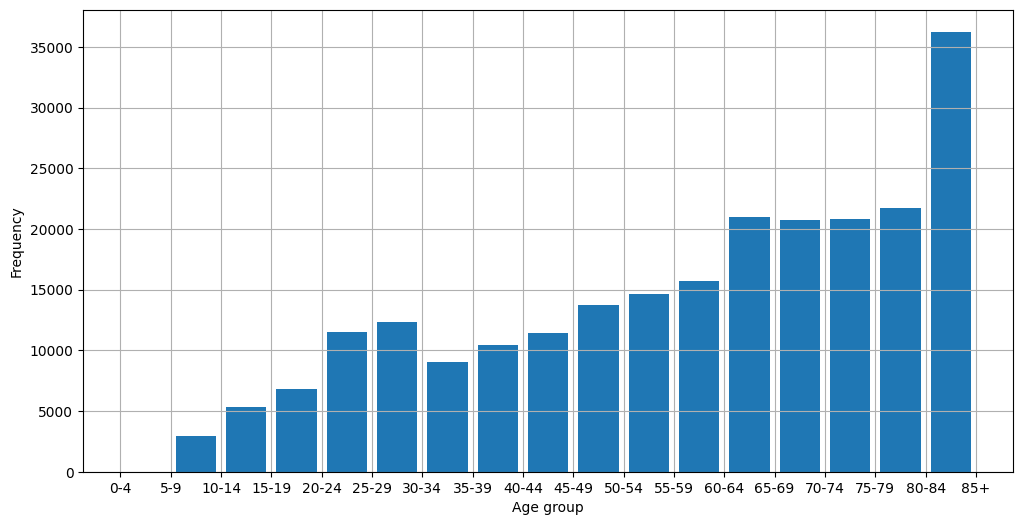

In [5]:
# 연령대코드(5세단위)를 그래프로 그립니다.
figure = plt.figure(figsize=(12, 6))
df['AGE_GROUP'].hist(bins=range(1, 19), rwidth=0.8)
plt.xlabel('Age group')
plt.ylabel('Frequency')
plt.xticks(range(1, 19), ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'])
plt.show()

## Adjacency Matrix

In [6]:
from itertools import combinations
from collections import Counter

In [7]:
def process_patient_data(patient_groups):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()

    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        prescriptions = group.groupby('pid')['mi_code'].apply(list)

        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()

        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 처방 내 각 약물 주성분의 발생 횟수 계산
            med_counts = Counter(meds)

            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            for med, count in med_counts.items():
                if count > 1:
                    patient_self_loops.add(med)

            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)

        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)

        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        for med in patient_self_loops:
            pair_counts[(med, med)] += 1

    return pair_counts

In [8]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))

    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)

    return adj_matrix

In [9]:
# 약품 코드를 인덱스로 매핑
unique_meds = df["mi_code"].unique()
med_to_index = {med: idx for idx, med in enumerate(unique_meds)}

# 환자별 그룹화
patient_groups = df.groupby('uid')

# 페어 카운트 처리
pair_counts = process_patient_data(patient_groups)

# 인접 행렬 생성
adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)

# 인접 행렬을 데이터프레임으로 변환
df_adjacency_matrix = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)

In [10]:
# 인접 행렬의 일부만 출력합니다.
df_adjacency_matrix.iloc[:5, :5]

,495501ACE,242901ACH,196204ATB,107501ATB,209305ATR
495501ACE,10.0,30.0,1.0,1.0,4.0
242901ACH,30.0,11.0,40.0,4.0,15.0
196204ATB,1.0,40.0,21.0,1.0,14.0
107501ATB,1.0,4.0,1.0,69.0,1.0
209305ATR,4.0,15.0,14.0,1.0,1.0


In [11]:
# 주성분 매핑 데이터프레임을 불러옵니다.
df_mapping = pd.read_csv('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/anti_depressant_mapping.csv')

# 주성분 이름을 약자로 변환한 컬럼을 추가합니다.
df_mapping['주성분약자'] = df_mapping['주성분명'].apply(lambda x: x[:3])

# 주성분 코드를 주성분 이름으로 매핑하는 딕셔너리를 생성합니다.
mi_code_to_abbrev = df_mapping.set_index('주성분코드')['주성분약자'].to_dict()


## 그래프 시각화

In [12]:
import networkx as nx
# adjacency matrix를 networkx 그래프로 변환합니다.
G_coprescribed = nx.from_pandas_adjacency(df_adjacency_matrix)

In [13]:
encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
encode_abbrev

{'esc': 0,
 'flu': 1,
 'par': 2,
 'ser': 3,
 'bup': 4,
 'mir': 5,
 'tra': 6,
 'des': 7,
 'dul': 8,
 'ven': 9,
 'ami': 10,
 'clo': 11,
 'imi': 12,
 'nor': 13,
 'sel': 14,
 'met': 15,
 'ago': 16,
 'ket': 17}

In [14]:
mi_code_to_abbrev

{'474801ATB': 'esc',
 '474801ATD': 'esc',
 '474802ATB': 'esc',
 '474802ATD': 'esc',
 '474803ATB': 'esc',
 '474803ATD': 'esc',
 '474804ATB': 'esc',
 '161501ACH': 'flu',
 '161501ATB': 'flu',
 '161502ACH': 'flu',
 '161502ATB': 'flu',
 '161502ATD': 'flu',
 '209301ATB': 'par',
 '209302ATB': 'par',
 '209304ATR': 'par',
 '209305ATR': 'par',
 '227001ATB': 'ser',
 '227002ATB': 'ser',
 '227003ATB': 'ser',
 '428101ATB': 'bup',
 '428102ATR': 'bup',
 '428103ATR': 'bup',
 '196201ATB': 'mir',
 '196201ATD': 'mir',
 '196202ATB': 'mir',
 '196202ATD': 'mir',
 '196203ATB': 'mir',
 '196204ATB': 'mir',
 '196204ATD': 'mir',
 '242901ACH': 'tra',
 '242901ATB': 'tra',
 '242902ATB': 'tra',
 '242903ATR': 'tra',
 '626401ATR': 'des',
 '626402ATR': 'des',
 '687601ATR': 'des',
 '687602ATR': 'des',
 '687701ATR': 'des',
 '687702ATR': 'des',
 '687703ATR': 'des',
 '495501ACE': 'dul',
 '495502ACE': 'dul',
 '247502ACR': 'ven',
 '247504ACR': 'ven',
 '107501ATB': 'ami',
 '107502ATB': 'ami',
 '107504ATB': 'ami',
 '136301ACH':

In [15]:
node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G_coprescribed.nodes]
node_color_by_abbrev

[8,
 6,
 5,
 10,
 2,
 6,
 4,
 3,
 0,
 2,
 3,
 16,
 8,
 0,
 2,
 10,
 13,
 4,
 6,
 1,
 0,
 5,
 12,
 0,
 9,
 5,
 15,
 13,
 1,
 15,
 15,
 15,
 1,
 15,
 3,
 9,
 11,
 15,
 7,
 4,
 7,
 15,
 15,
 1,
 5,
 10,
 7,
 7,
 15,
 7,
 7,
 6,
 2,
 14,
 1,
 15,
 11,
 5,
 15,
 5]

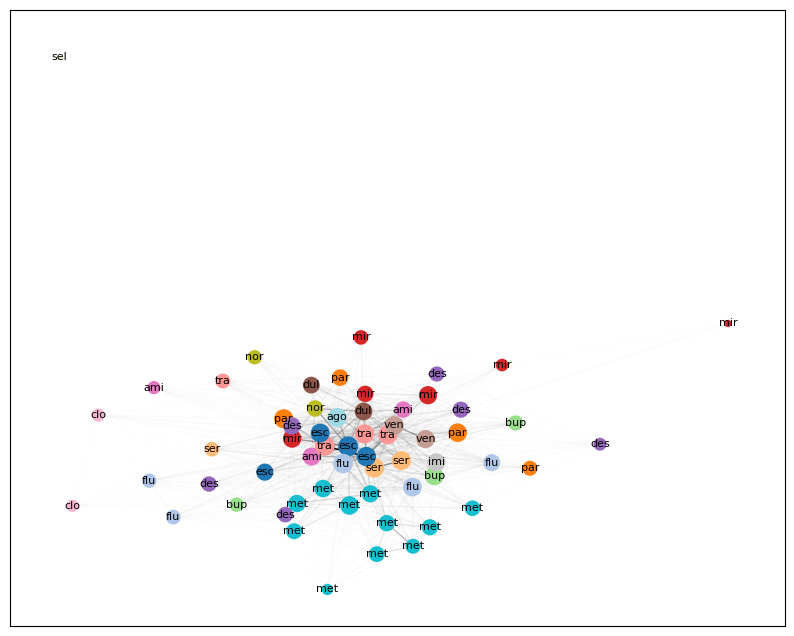

In [16]:
import networkx as nx
# 그래프를 그립니다.
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_coprescribed, seed=42,k=0.5)

# 노드의 크기를 degree centrality에 비례하게 설정합니다.
node_size = [G_coprescribed.degree(node) * 3 for node in G_coprescribed.nodes]

# 노드의 색상을 주성분 이름의 약자에 따라 설정합니다.
encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G_coprescribed.nodes]
nx.draw_networkx_nodes(G_coprescribed, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

# 엣지의 투명도를 weight에 비례하게 설정합니다.
max_weight = max([d['weight'] for u, v, d in G_coprescribed.edges(data=True)])
for edge in G_coprescribed.edges(data="weight"):
    nx.draw_networkx_edges(G_coprescribed, pos, edgelist=[edge], alpha=edge[2] / max_weight)

# 인덱스를 이용한 노드 레이블링을 합니다.
labels = {node: mi_code_to_abbrev[node] for node in G_coprescribed.nodes}
nx.draw_networkx_labels(G_coprescribed, pos, labels, font_size=8)

plt.show()

In [ ]:
import os
# 저장할 파일 경로 설정 (현재 작업 디렉토리 기준)
current_dir = os.getcwd()  # 현재 작업 디렉토리 확인
file_name = '2021_anti_depressant_final.csv'  # 저장할 파일 이름
file_path = os.path.join(current_dir, file_name)  # 경로와 파일 이름 결합

# 데이터프레임을 CSV 파일로 저장 (인코딩: cp949)
df.to_csv(file_path, encoding='cp949', index=False)

## 병용금기 리스트 불러오기

In [ ]:
# 병용금기 리스트 불러오기
df = pd.read_csv('D:\소셜네트워크과학\Drug_Coprescription_Network_Analysis\data\병용금기 성분리스트_241011.csv', encoding = 'cp949')
df.head()

,연번,유효성분 '1',유효성분 '2',허가사항,비고
0,1,acemetacin,diflunisal,중증의 위장관계 이상반응,NaN
1,2,acemetacin,methotrexate(분류번호 : 421),신세뇨관에서 Methotrexate 배설이 지연되어 Methotrexate의 혈액학...,methotrexate 1주에 15mg 이상 투여시
2,3,acetazolamide,methazolamide,신장결석 형성 위험 증가,NaN
3,4,acetazolamide,topiramate,신결석,NaN
4,5,acitretin,doxycycline,두개내압 증가,NaN


In [ ]:
# 성분명 리스트 읽어오기
with open('D:\소셜네트워크과학\Drug_Coprescription_Network_Analysis\data\항우울제 성분명(영어).txt','r') as f:
    ingredient_name_cap = f.read().splitlines()

ingredient_name =[]
for item in ingredient_name_cap:
    item = item.lower()
    ingredient_name.append(item)

ingredient_name

['citalopram',
 'escitalopram',
 'fluoxetine',
 'fluvoxamine',
 'paroxetine',
 'sertraline',
 'vilazodone',
 'bupropion',
 'mirtazapine',
 'trazodone',
 'desvenlafaxine',
 'duloxetine',
 'levomilnacipran',
 'venlafaxine',
 'amitriptyline',
 'amoxapine',
 'clomipramine',
 'desipramine',
 'doxepin',
 'imipramine',
 'maprotiline',
 'nortriptyline',
 'protriptyline',
 'trimipramine',
 'isocarboxazid',
 'phenelzine',
 'selegiline',
 'tranylcypromine',
 'dextroamphetamine',
 'methylphenidate',
 'agomelatine',
 'ketamine',
 'esketamine']

In [ ]:
rows =[]
for chunk in pd.read_csv('D:\소셜네트워크과학\Drug_Coprescription_Network_Analysis\data\병용금기 성분리스트_241011.csv',encoding='cp949',chunksize=100000):
    rows.append(chunk[(chunk["유효성분 '1'"].isin(ingredient_name)) & (chunk["유효성분 '2'"].isin(ingredient_name))])

df = pd.concat(rows)

In [ ]:
df

,연번,유효성분 '1',유효성분 '2',허가사항,비고
52,53,amitriptyline,selegiline,"이상고열, 전신경련, 발한, 불온, 혼수등",NaN
53,54,amoxapine,selegiline,"세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN
140,141,clomipramine,selegiline,"고혈압위기, 이상고열증, 근간대경련, 격월성 발작, 정신착란, 혼수 등",NaN
179,180,doxepin,selegiline,"근독성, 간질, 세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN
222,224,fluvoxamine,selegiline,"세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN
239,241,imipramine,selegiline,"근독성, 간질, 세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN
402,404,methylphenidate,selegiline,고혈압성 위기(현저한 혈압상승),NaN
424,428,mirtazapine,selegiline,"구역, 구토, 안면홍조, 어지러움, 진전, 산동, 강직, 발한, 고온증, 심장지표의...",NaN
451,455,nortriptyline,selegiline,"근독성, 간질, 세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN
458,462,paroxetine,selegiline,"세로토닌성 증후군(고혈압, 고열, 간대성 근경련, 정신상태 변화 등)",NaN


In [ ]:
# 인접리스트를 생성한다.
selected_columns = df[["유효성분 '1'", "유효성분 '2'"]]

adj_list = {}
for ingredient1, ingredient2 in selected_columns.groupby("유효성분 '1'")["유효성분 '2'"]:
    adj_list[ingredient1] = list(ingredient2)

adj_list

{'agomelatine': ['fluvoxamine'],
 'amitriptyline': ['selegiline'],
 'amoxapine': ['selegiline'],
 'clomipramine': ['selegiline'],
 'desvenlafaxine': ['selegiline'],
 'doxepin': ['selegiline'],
 'duloxetine': ['fluvoxamine', 'selegiline'],
 'fluvoxamine': ['selegiline'],
 'imipramine': ['selegiline'],
 'methylphenidate': ['selegiline'],
 'mirtazapine': ['selegiline'],
 'nortriptyline': ['selegiline'],
 'paroxetine': ['selegiline'],
 'selegiline': ['bupropion', 'fluoxetine', 'sertraline', 'venlafaxine']}

In [ ]:
# 모든 고유한 노드 식별
nodes = sorted(set(adj_list.keys()).union(*adj_list.values()))

# 빈 인접 행렬 초기화
adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes)

# 인접 행렬 채우기
for source, targets in adj_list.items():
    for target in targets:
        adj_matrix.loc[source, target] = 1

# 결과 출력
adj_matrix

,agomelatine,amitriptyline,amoxapine,bupropion,clomipramine,desvenlafaxine,doxepin,duloxetine,fluoxetine,fluvoxamine,imipramine,methylphenidate,mirtazapine,nortriptyline,paroxetine,selegiline,sertraline,venlafaxine
agomelatine,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
amitriptyline,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
amoxapine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
bupropion,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
clomipramine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
desvenlafaxine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
doxepin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
duloxetine,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
fluoxetine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fluvoxamine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# adjacency matrix를 networkx 그래프로 변환합니다.
G_contraindicated = nx.from_pandas_adjacency(adj_matrix)

Text(0.5, 1.0, 'incompatible antidepressant ingredient Network')

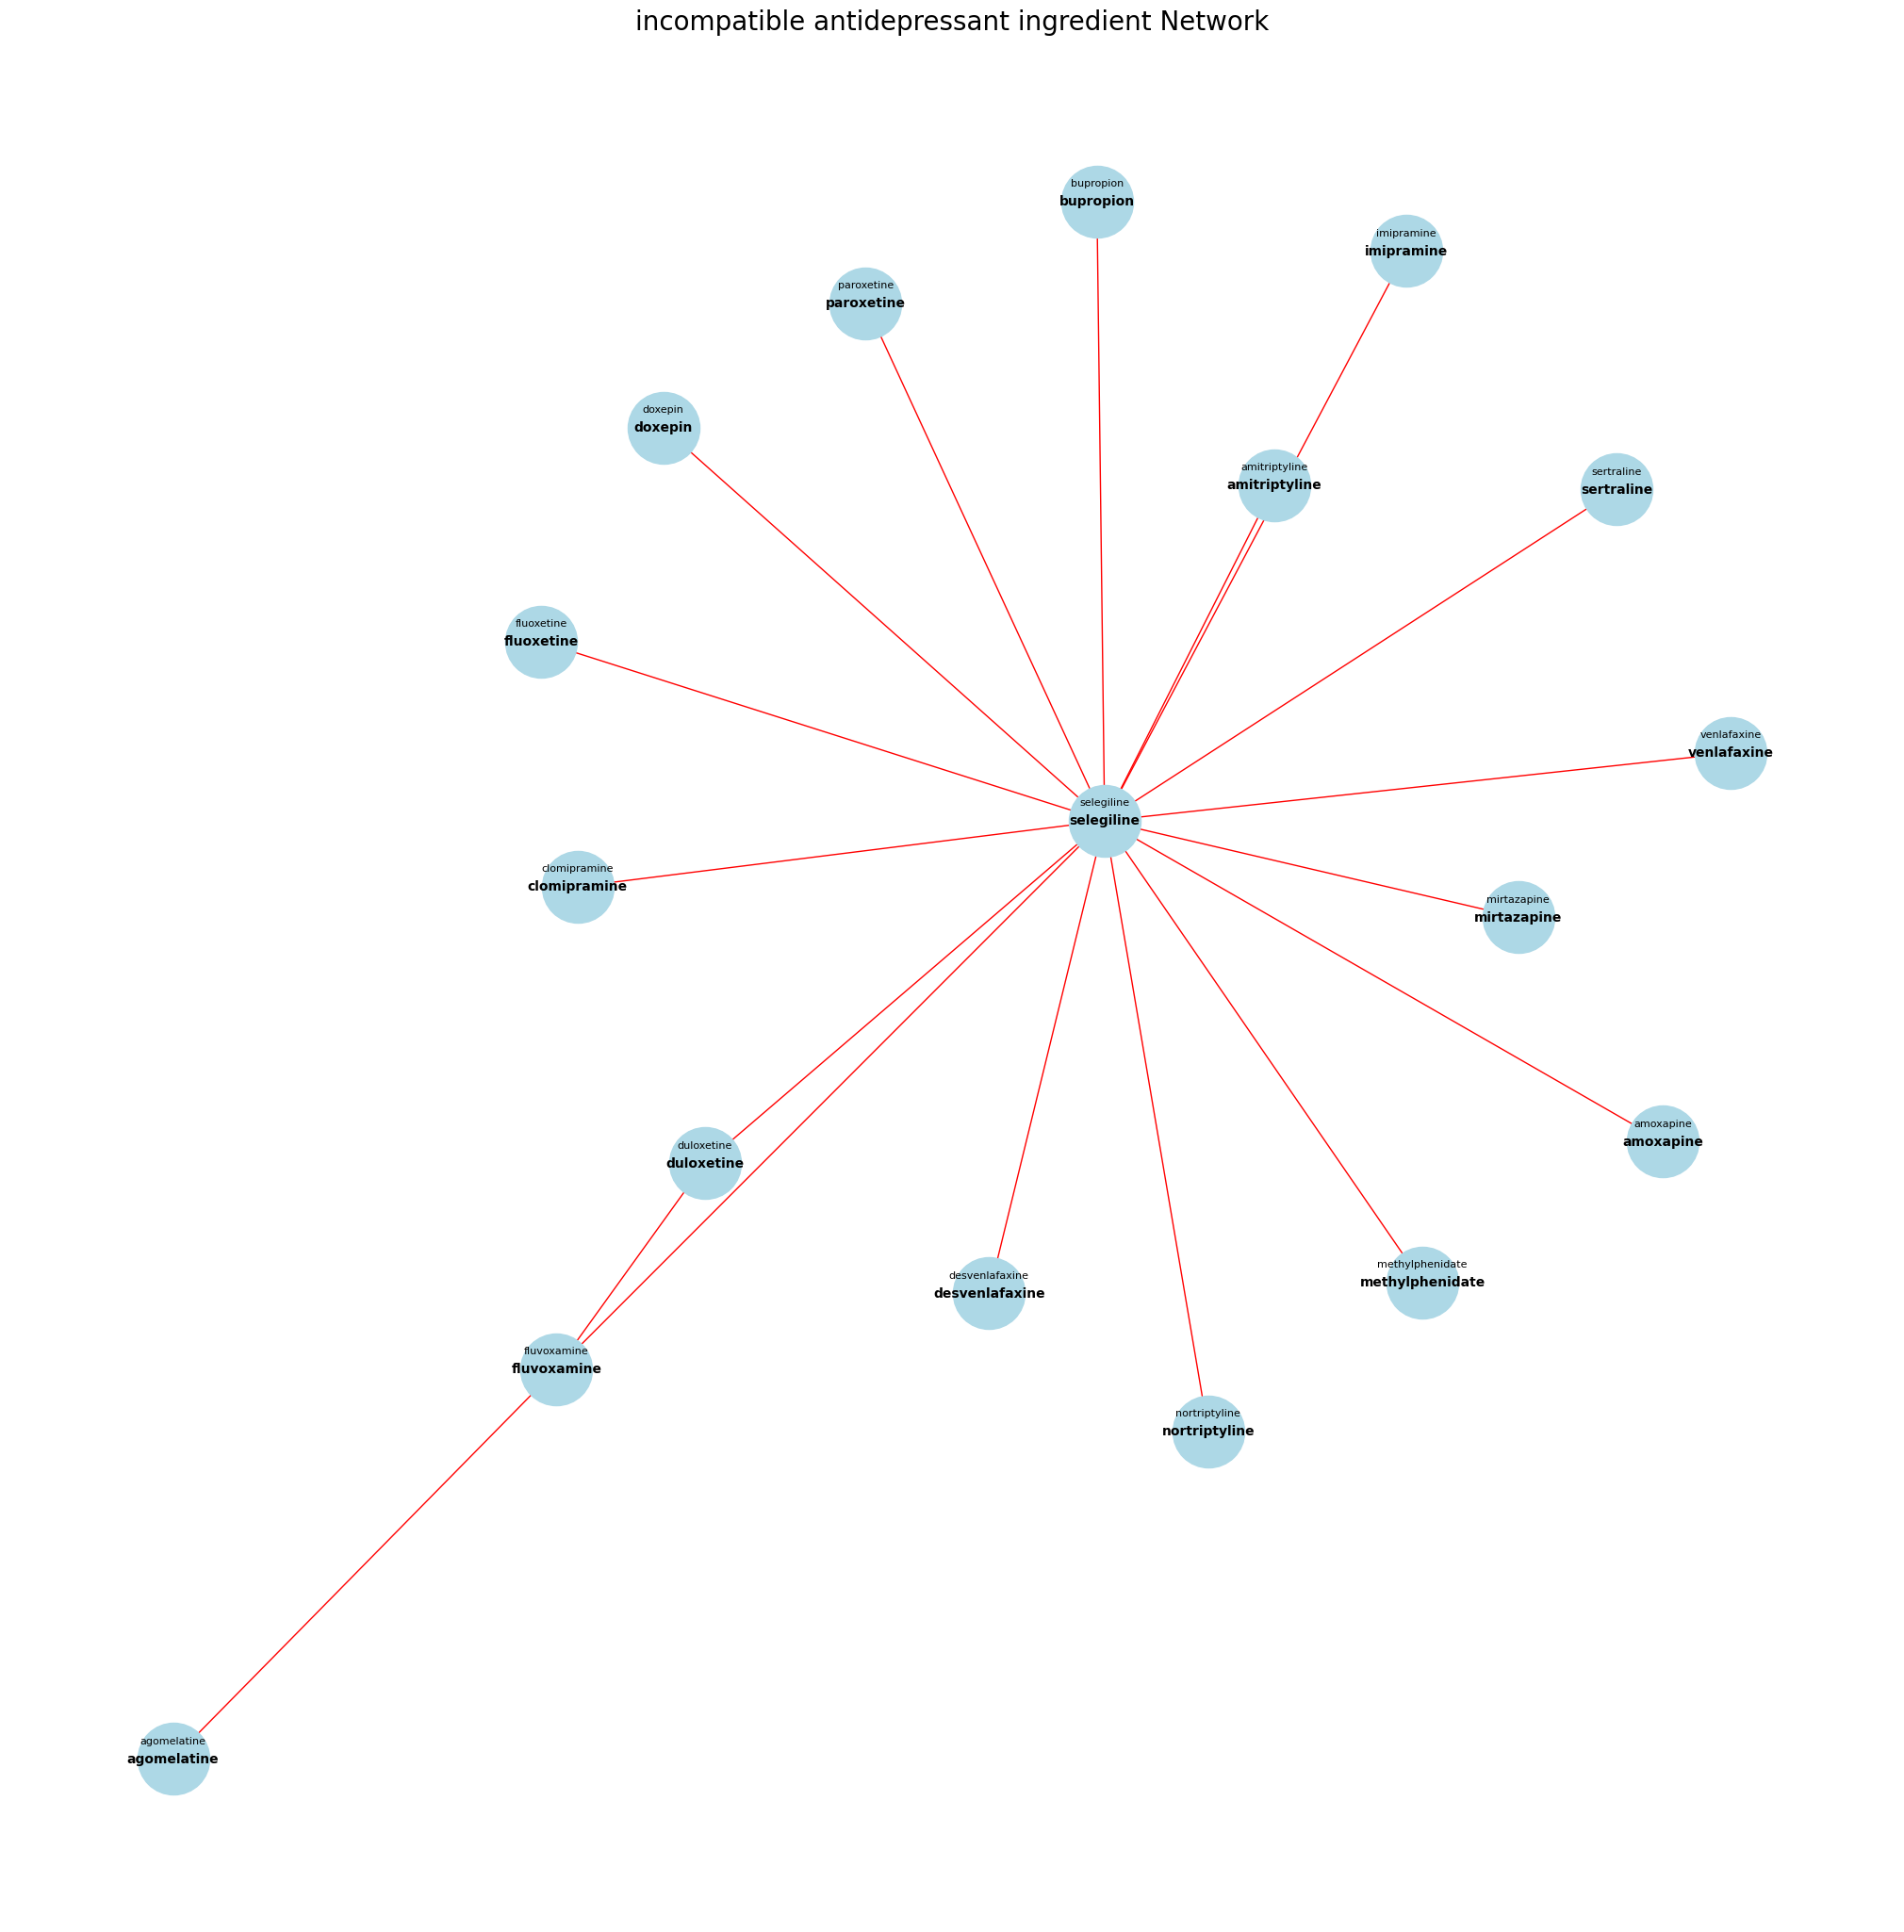

In [ ]:
# 그래프 레이아웃 설정 (여기서는 spring layout 사용)  # spring(용수철) layout
pos = nx.spring_layout(G_contraindicated, k=0.5, iterations=50)

# 그래프 그리기
plt.figure(figsize=(20, 20))
nx.draw(G_contraindicated, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=10, font_weight='bold',
        edge_color='red', width=1, arrows=True)

# 노드 레이블 위치 조정
label_pos = {k: [v[0], v[1]+0.02] for k, v in pos.items()}
nx.draw_networkx_labels(G_contraindicated, label_pos, font_size=8)

# 그래프 제목 설정
plt.title("incompatible antidepressant ingredient Network", fontsize=20)

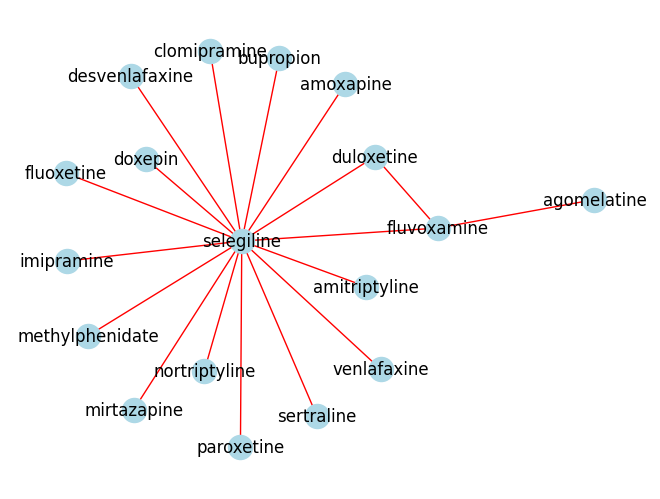

In [ ]:
#kawai kamada layout
pos = nx.kamada_kawai_layout(G_contraindicated)
nx.draw(G_contraindicated, pos, with_labels=True, node_color='lightblue', edge_color='red')

## 위의 두 인접행렬에서 나온 그래프들의 병합 : 병용금기인 약들이 같이 처방되었으면 다른 색상의 엣지로 표현

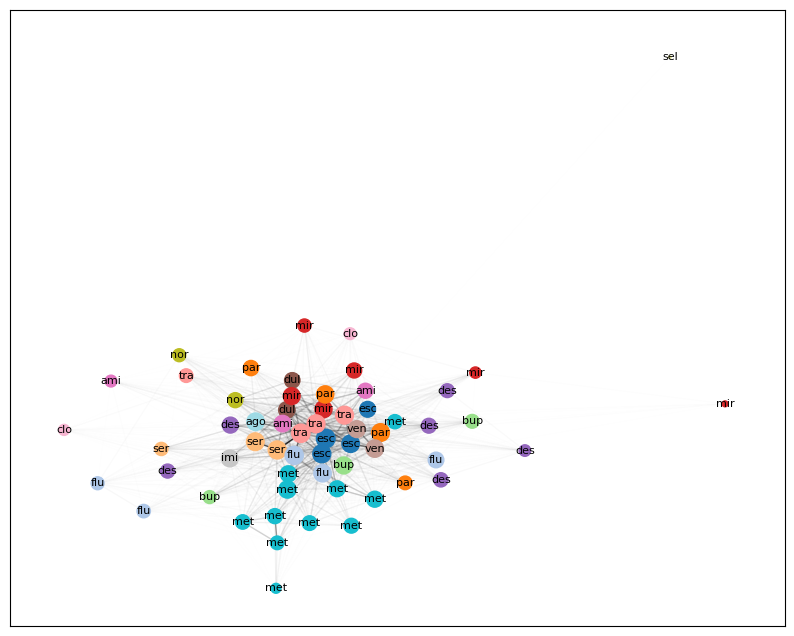

In [ ]:
# 그래프를 그립니다.
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_coprescribed, seed=42,k=0.5)

# 노드의 크기를 degree centrality에 비례하게 설정합니다.
node_size = [G_coprescribed.degree(node) * 3 for node in G_coprescribed.nodes]

# 노드의 색상을 주성분 이름의 약자에 따라 설정합니다.
encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G_coprescribed.nodes]
nx.draw_networkx_nodes(G_coprescribed, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)

# 엣지 색상 정의
edge_colors = []
for edge in G_coprescribed.edges():
    # 양방향 엣지가 병용 금기 네트워크에 있는지 확인
    if G_contraindicated.has_edge(*edge) or G_contraindicated.has_edge(*reversed(edge)):
        edge_colors.append('red')   # 병용 금기 엣지
    else:
        edge_colors.append('black') # 일반 엣지

# 엣지의 투명도를 weight에 비례하게 설정합니다.
max_weight = max([d['weight'] for u, v, d in G_coprescribed.edges(data=True)])
for edge in G_coprescribed.edges(data="weight"):
    nx.draw_networkx_edges(G_coprescribed, pos, edgelist=[edge], alpha=edge[2] / max_weight)

# 인덱스를 이용한 노드 레이블링을 합니다.
labels = {node: mi_code_to_abbrev[node] for node in G_coprescribed.nodes}
nx.draw_networkx_labels(G_coprescribed, pos, labels, font_size=8)

plt.show()

In [ ]:
# G_coprescribed의 각 엣지가 G_contraindicated에 있는지 확인
num_red =0
num_black = 0
for edge in G_coprescribed.edges():
    # 양방향으로 병용 금기 네트워크에 있는지 확인
    if G_contraindicated.has_edge(*edge) or G_contraindicated.has_edge(*reversed(edge)):
        num_red +=1
    else:
        num_black +=1

# 결과 출력
print("Edge red:", num_red)
print("Edge black:", num_black)

Edge red: 0
Edge black: 1193


###병용금기 성분이 같이 쓰이지 않았음을 시사한다.

## 다음으로 노드들의 centrality를 알아보자.

### degree centrality

In [ ]:
df_mapping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Drug_Coprescription_Network_Analysis/data/anti_depressant_mapping.csv', index_col = '주성분코드')

In [ ]:
# Degree Centrality 정규화 과정에서 문제가 없는지 확인
total_nodes = len(G_coprescribed.nodes)
degree_centrality = {node: degree / (total_nodes - 1) for node, degree in G_coprescribed.degree()}

In [ ]:
# Degree Centrality 계산
degree_centrality = nx.degree_centrality(G_coprescribed)

# Degree Centrality를 내림차순으로 정렬
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
print("Degree Centrality (내림차순):")
for node, centrality in sorted_degree_centrality:
    name = df_mapping.loc[node, '주성분명'] if node in df_mapping.index else "Unknown"
    print(f"{node} ({name}): {centrality:.4f}")

Degree Centrality (내림차순):
474802ATB (escitalopram): 1.0169
242901ATB (trazodone): 0.9831
161502ACH (fluoxetine): 0.9661
227001ATB (sertraline): 0.9492
474801ATB (escitalopram): 0.9492
242901ACH (trazodone): 0.9322
242902ATB (trazodone): 0.9322
209302ATB (paroxetine): 0.9153
227002ATB (sertraline): 0.9153
613101ATB (agomelatine): 0.8983
474803ATB (escitalopram): 0.8983
247502ACR (venlafaxine): 0.8814
161501ACH (fluoxetine): 0.8814
209304ATR (paroxetine): 0.8644
193201ATB (methylphenidate): 0.8644
196204ATB (mirtazapine): 0.8475
428102ATR (bupropion): 0.8475
196201ATB (mirtazapine): 0.8305
173701ATB (imipramine): 0.8305
247504ACR (venlafaxine): 0.8305
107501ATB (amitriptyline): 0.7966
495501ACE (duloxetine): 0.7797
193203ATR (methylphenidate): 0.7627
193204ATR (methylphenidate): 0.7458
626401ATR (desvenlafaxine): 0.7458
474804ATB (escitalopram): 0.7288
193206ATR (methylphenidate): 0.7288
161502ATD (fluoxetine): 0.7119
495502ACE (duloxetine): 0.6949
209305ATR (paroxetine): 0.6780
107504AT


###왜
###474802ATB (escitalopram): 1.0169
###(1보다 큰 중심성이 나오는거지?)
### => self-loop 포함하기 때문

In [ ]:
# 중복 엣지가 있는지 확인 (다중 그래프인 경우)
if isinstance(G_coprescribed, nx.MultiGraph):
    print("다중 그래프입니다. 중복된 엣지가 있을 수 있습니다.")
else:
    print("단일 그래프입니다.")

단일 그래프입니다.


In [ ]:
# 특정 노드('474802ATB')의 차수 및 연결된 엣지 확인
node = '474802ATB'
print(f"'{node}'의 차수: {G_coprescribed.degree(node)}")
print(f"'{node}'와 연결된 엣지들: {list(G_coprescribed.edges(node))}")
list(G_coprescribed.edges(node))[0][1]


# '474802ATB' 노드와 연결된 모든 엣지 리스트
edges = list(G_coprescribed.edges(node))

# 중복된 엣지를 찾기 위한 루프
for i in range(len(edges)):
    for j in range(i + 1, len(edges)):  # i 이후의 엣지들과 비교
        if edges[i][1] == edges[j][1]:  # 두 엣지가 동일한 노드와 연결되어 있는지 확인
            print(f"중복된 엣지: {edges[i]}와 {edges[j]}")

'474802ATB'의 차수: 60
'474802ATB'와 연결된 엣지들: [('474802ATB', '495501ACE'), ('474802ATB', '242901ACH'), ('474802ATB', '196204ATB'), ('474802ATB', '107501ATB'), ('474802ATB', '209305ATR'), ('474802ATB', '242901ATB'), ('474802ATB', '428102ATR'), ('474802ATB', '227001ATB'), ('474802ATB', '474802ATB'), ('474802ATB', '209302ATB'), ('474802ATB', '227002ATB'), ('474802ATB', '613101ATB'), ('474802ATB', '495502ACE'), ('474802ATB', '474801ATB'), ('474802ATB', '209304ATR'), ('474802ATB', '107504ATB'), ('474802ATB', '203401ATB'), ('474802ATB', '428103ATR'), ('474802ATB', '242902ATB'), ('474802ATB', '161502ACH'), ('474802ATB', '474803ATB'), ('474802ATB', '196201ATB'), ('474802ATB', '173701ATB'), ('474802ATB', '474804ATB'), ('474802ATB', '247502ACR'), ('474802ATB', '196201ATD'), ('474802ATB', '193207ACR'), ('474802ATB', '203402ATB'), ('474802ATB', '161501ACH'), ('474802ATB', '193205ACR'), ('474802ATB', '193202ACR'), ('474802ATB', '193201ACR'), ('474802ATB', '161501ATB'), ('474802ATB', '193203ATR'), ('474

### Closeness Centrality

In [ ]:
# Closeness Centrality 계산
closeness_centrality = nx.closeness_centrality(G_coprescribed)

# Closeness Centrality를 내림차순으로 정렬
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
print("Closeness Centrality (내림차순):")
for node, centrality in sorted_closeness_centrality:
    name = df_mapping.loc[node, '주성분명'] if node in df_mapping.index else "Unknown"
    print(f"{node} ({name}): {centrality:.4f}")

Closeness Centrality (내림차순):
474802ATB (escitalopram): 0.9833
242901ATB (trazodone): 0.9516
161502ACH (fluoxetine): 0.9365
227001ATB (sertraline): 0.9219
474801ATB (escitalopram): 0.9219
242901ACH (trazodone): 0.9077
242902ATB (trazodone): 0.9077
209302ATB (paroxetine): 0.8939
227002ATB (sertraline): 0.8939
613101ATB (agomelatine): 0.8806
474803ATB (escitalopram): 0.8806
247502ACR (venlafaxine): 0.8676
161501ACH (fluoxetine): 0.8676
209304ATR (paroxetine): 0.8551
193201ATB (methylphenidate): 0.8551
196204ATB (mirtazapine): 0.8429
428102ATR (bupropion): 0.8429
196201ATB (mirtazapine): 0.8310
173701ATB (imipramine): 0.8310
247504ACR (venlafaxine): 0.8310
107501ATB (amitriptyline): 0.8082
495501ACE (duloxetine): 0.7973
193204ATR (methylphenidate): 0.7973
193203ATR (methylphenidate): 0.7867
626401ATR (desvenlafaxine): 0.7763
474804ATB (escitalopram): 0.7662
193206ATR (methylphenidate): 0.7662
161502ATD (fluoxetine): 0.7564
495502ACE (duloxetine): 0.7468
196202ATB (mirtazapine): 0.7468
2093

### Eigenvector Centrality

In [ ]:
# eigenvector Centrality 계산
eigenvector_centrality = nx.eigenvector_centrality(G_coprescribed)

# eigenvector Centrality를 내림차순으로 정렬
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
print("Eigenvector_centrality (내림차순):")
for node, centrality in sorted_eigenvector_centrality:
    name = df_mapping.loc[node, '주성분명'] if node in df_mapping.index else "Unknown"
    print(f"{node} ({name}): {centrality:.4f}")

Eigenvector_centrality (내림차순):
474802ATB (escitalopram): 0.1720
242901ATB (trazodone): 0.1720
161502ACH (fluoxetine): 0.1696
474801ATB (escitalopram): 0.1680
227001ATB (sertraline): 0.1667
242902ATB (trazodone): 0.1643
227002ATB (sertraline): 0.1641
242901ACH (trazodone): 0.1627
613101ATB (agomelatine): 0.1620
474803ATB (escitalopram): 0.1616
209302ATB (paroxetine): 0.1613
247502ACR (venlafaxine): 0.1590
161501ACH (fluoxetine): 0.1576
209304ATR (paroxetine): 0.1569
193201ATB (methylphenidate): 0.1556
428102ATR (bupropion): 0.1551
196204ATB (mirtazapine): 0.1528
196201ATB (mirtazapine): 0.1524
173701ATB (imipramine): 0.1521
247504ACR (venlafaxine): 0.1509
495501ACE (duloxetine): 0.1441
107501ATB (amitriptyline): 0.1428
193203ATR (methylphenidate): 0.1403
193204ATR (methylphenidate): 0.1392
626401ATR (desvenlafaxine): 0.1387
161502ATD (fluoxetine): 0.1363
193206ATR (methylphenidate): 0.1337
474804ATB (escitalopram): 0.1334
495502ACE (duloxetine): 0.1298
209305ATR (paroxetine): 0.1282
196

### Pagerank centrality

In [ ]:
# Pagerank Centrality 계산
pagerank_centrality = nx.pagerank(G_coprescribed)

# Pagerank Centrality를 내림차순으로 정렬
sorted_pagerank_centrality = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

# 결과 출력
print("Pagerank_centrality (내림차순):")
for node, centrality in sorted_pagerank_centrality:
    name = df_mapping.loc[node, '주성분명'] if node in df_mapping.index else "Unknown"
    print(f"{node} ({name}): {centrality:.4f}")

Pagerank_centrality (내림차순):
474801ATB (escitalopram): 0.0676
242901ATB (trazodone): 0.0630
474802ATB (escitalopram): 0.0543
107501ATB (amitriptyline): 0.0387
161502ACH (fluoxetine): 0.0366
242902ATB (trazodone): 0.0359
495501ACE (duloxetine): 0.0280
203401ATB (nortriptyline): 0.0272
193203ATR (methylphenidate): 0.0265
242901ACH (trazodone): 0.0260
613101ATB (agomelatine): 0.0248
474803ATB (escitalopram): 0.0233
227001ATB (sertraline): 0.0233
193206ATR (methylphenidate): 0.0215
161501ACH (fluoxetine): 0.0212
196201ATB (mirtazapine): 0.0207
196204ATB (mirtazapine): 0.0201
209302ATB (paroxetine): 0.0198
227002ATB (sertraline): 0.0196
107504ATB (amitriptyline): 0.0190
247502ACR (venlafaxine): 0.0189
247504ACR (venlafaxine): 0.0184
209304ATR (paroxetine): 0.0168
173701ATB (imipramine): 0.0168
428102ATR (bupropion): 0.0160
193201ATB (methylphenidate): 0.0151
495502ACE (duloxetine): 0.0146
474804ATB (escitalopram): 0.0136
193201ACR (methylphenidate): 0.0133
196202ATB (mirtazapine): 0.0125
193

## Basic stat

In [ ]:
import statistics as stat

def basic_stat_info(data, data_desc):
    print(data_desc.center(30, '-'))
    print(f'[Max]: {max(data):.3f}, [Min]:{min(data):.3f}')
    print(f'[Mean]: {stat.mean(data):.3f}')
    print(f'[Median]: {stat.median(data):.3f}')

In [ ]:
degree_seq = [G_coprescribed.degree(n) for n in G_coprescribed.nodes]
basic_stat_info(degree_seq, 'Degree')
basic_stat_info(degree_centrality.values(), 'Degree Centrality')
basic_stat_info(closeness_centrality.values(), 'closeness Centrality')
basic_stat_info(eigenvector_centrality.values(), 'eigenvector Centrality')
basic_stat_info(pagerank_centrality.values(), 'pagerank Centrality')

------------Degree------------
[Max]: 60.000, [Min]:1.000
[Mean]: 39.767
[Median]: 39.500
------Degree Centrality-------
[Max]: 1.017, [Min]:0.017
[Mean]: 0.674
[Median]: 0.669
-----closeness Centrality-----
[Max]: 0.983, [Min]:0.500
[Mean]: 0.757
[Median]: 0.742
----eigenvector Centrality----
[Max]: 0.172, [Min]:0.004
[Mean]: 0.124
[Median]: 0.128
-----pagerank Centrality------
[Max]: 0.068, [Min]:0.003
[Mean]: 0.017
[Median]: 0.012


### 노드 중심성 점수 분포 시각화하기

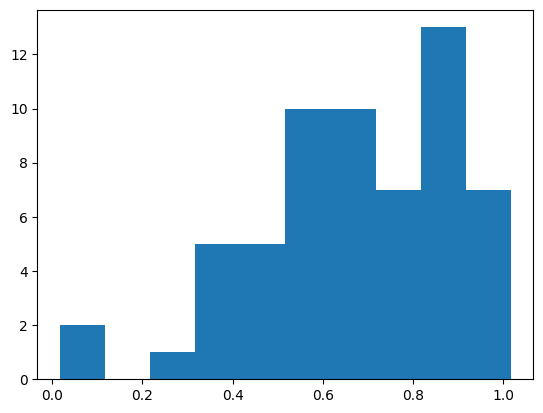

In [ ]:
#Histogram: Degree Centrality
counts, bins, patches = plt.hist(degree_centrality.values(), bins=10)

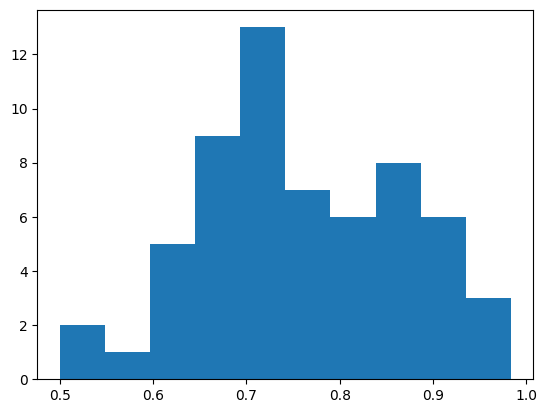

In [ ]:
#Histogram: Closeness Centrality
counts, bins, patches = plt.hist(closeness_centrality.values(), bins=10)

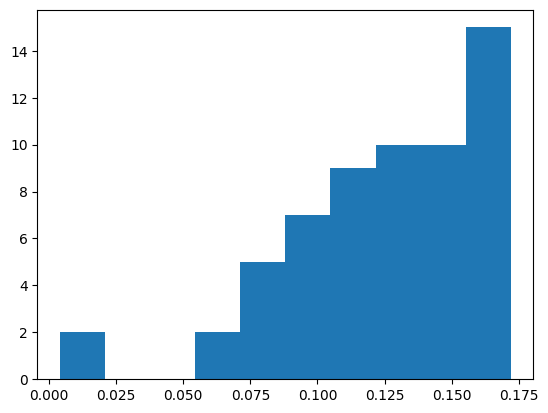

In [ ]:
#Histogram: Eigencevtor Centrality
counts, bins, patches = plt.hist(eigenvector_centrality.values(), bins=10)

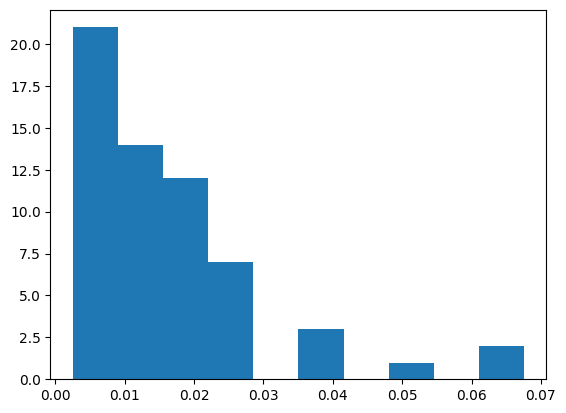

In [ ]:
#Histogram: Pagerank Centrality
counts, bins, patches = plt.hist(pagerank_centrality.values(), bins=10)

### degree vs closeness

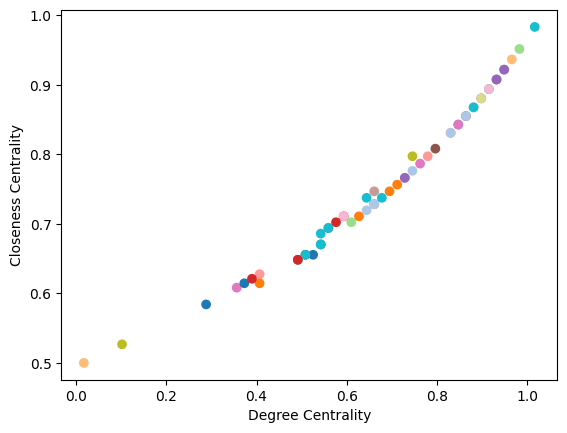

In [ ]:
x = [v for k, v in sorted(degree_centrality.items())]
y = [v for k, v in sorted(closeness_centrality.items())]


# scatter plot 생성
plt.scatter(x, y, c=node_color_by_abbrev, cmap='tab20')





plt.xlabel('Degree Centrality')
plt.ylabel('Closeness Centrality');

### degree VS eigenvector

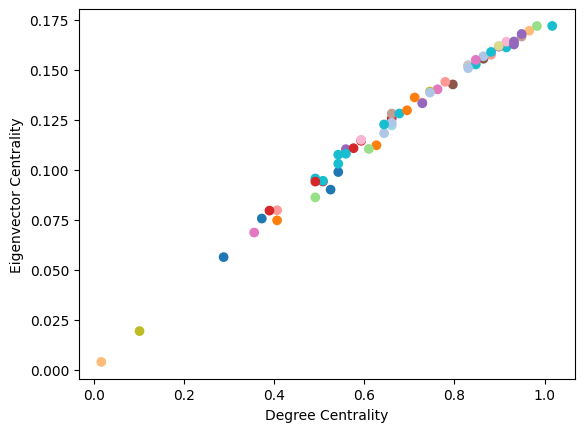

In [ ]:
x = [v for k, v in sorted(degree_centrality.items())]
y = [v for k, v in sorted(eigenvector_centrality.items())]



# scatter plot 생성
plt.scatter(x, y, c=node_color_by_abbrev, cmap='tab20')





plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality');

### Eigenvector VS Pagerank

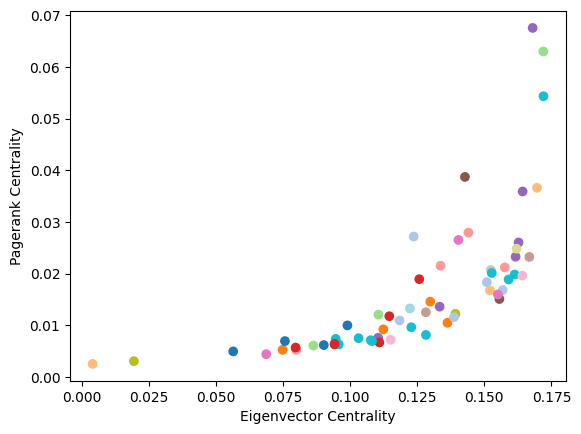

In [ ]:
x = [v for k, v in sorted(eigenvector_centrality.items())]
y = [v for k, v in sorted(pagerank_centrality.items())]



# scatter plot 생성
plt.scatter(x, y, c=node_color_by_abbrev, cmap='tab20')





plt.xlabel('Eigenvector Centrality')
plt.ylabel('Pagerank Centrality');

## Subplot 그려보기


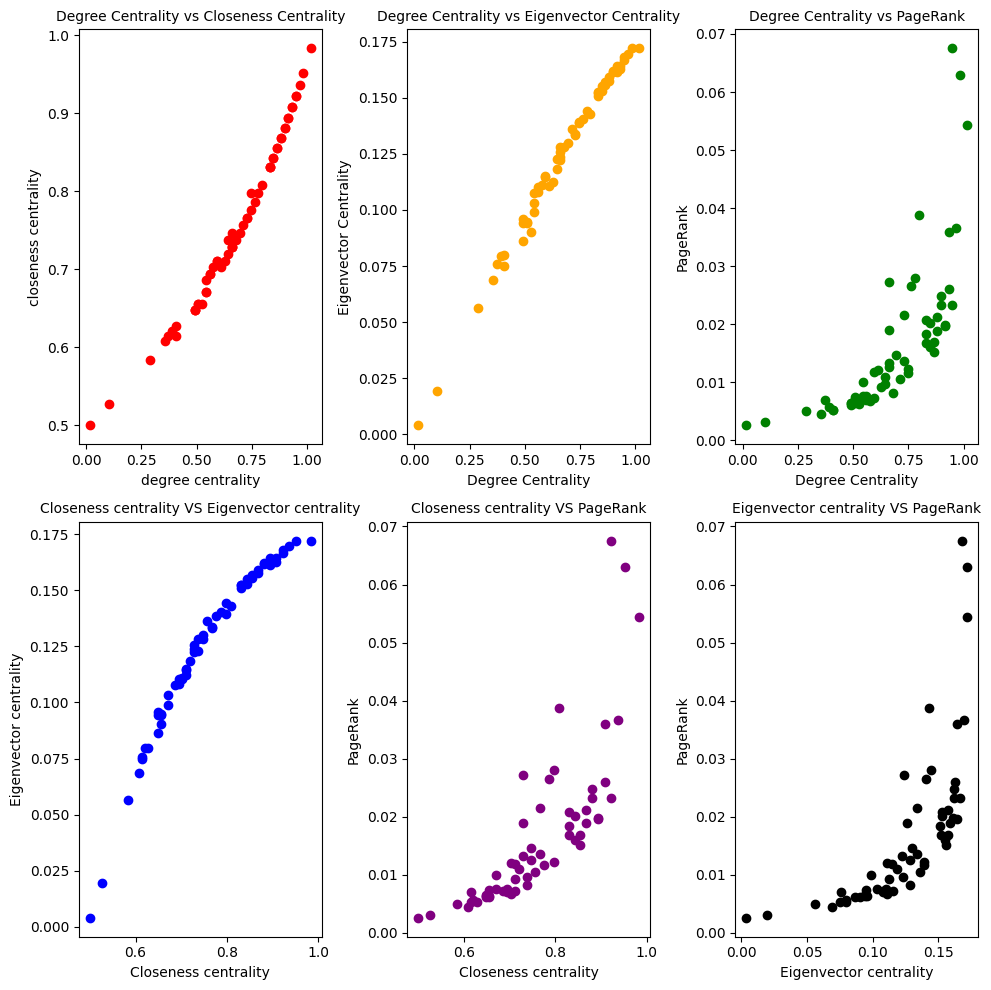

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Assuming G_coprescribed is your graph and df_mapping is your node mapping DataFrame

# Calculate centralities
degree_centrality = nx.degree_centrality(G_coprescribed)
closeness_centrality = nx.closeness_centrality(G_coprescribed)
eigenvector_centrality = nx.eigenvector_centrality(G_coprescribed)
pagerank = nx.pagerank(G_coprescribed)

# Sort centralities by node for consistency
sorted_nodes = sorted(degree_centrality.keys())

# Extract values for plotting
degree_values = [degree_centrality[node] for node in sorted_nodes]
closeness_values = [closeness_centrality[node] for node in sorted_nodes]
eigenvector_values = [eigenvector_centrality[node] for node in sorted_nodes]
pagerank_values = [pagerank[node] for node in sorted_nodes]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 10))


axs[0, 0].scatter(degree_values, closeness_values, color='red')
axs[0, 0].set_title('Degree Centrality vs Closeness Centrality', fontsize=10)
axs[0, 0].set_xlabel('degree centrality')
axs[0, 0].set_ylabel('closeness centrality')


axs[0, 1].scatter(degree_values, eigenvector_values, color='orange')
axs[0, 1].set_title('Degree Centrality vs Eigenvector Centrality', fontsize=10)
axs[0, 1].set_xlabel('Degree Centrality')
axs[0, 1].set_ylabel('Eigenvector Centrality')

axs[0, 2].scatter(degree_values, pagerank_values, color='green')
axs[0, 2].set_title('Degree Centrality vs PageRank', fontsize=10)
axs[0, 2].set_xlabel('Degree Centrality')
axs[0, 2].set_ylabel('PageRank')


axs[1, 0].scatter(closeness_values, eigenvector_values, color='blue')
axs[1, 0].set_title('Closeness centrality VS Eigenvector centrality', fontsize=10)
axs[1, 0].set_xlabel('Closeness centrality')
axs[1, 0].set_ylabel('Eigenvector centrality')


axs[1,1].scatter(closeness_values, pagerank_values, color='purple')
axs[1,1].set_title('Closeness centrality VS PageRank', fontsize=10)
axs[1,1].set_xlabel('Closeness centrality')
axs[1,1].set_ylabel('PageRank')

axs[1,2].scatter(eigenvector_values, pagerank_values, color='black')
axs[1,2].set_title('Eigenvector centrality VS PageRank', fontsize=10)
axs[1,2].set_xlabel('Eigenvector centrality')
axs[1,2].set_ylabel('PageRank')

#

plt.tight_layout()
plt.show()

# Part 1 : 2021년도 월별 density 추이 살펴보기

### 보고자 하는 것 : 시간이 지날수록 항우울제 네트워크의 density가 증가할 것이다. 
### => density가 증가한다 : 개인이 처방 받는 빈도(엣지 투명도) / 처방 받는 환자 수 / 한 번에 처방받는 항우울제 성분 수(엣지 수) 의 증가라고 볼 수 있지 않을까?

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from collections import Counter

import networkx as nx

In [69]:
df = pd.read_csv('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/2021_anti_depressant_final.csv')

In [70]:
df.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11
1,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11
2,2021,251575,764386,1,2,13,41,2021-09-13,196204ATB,1.0,1,30,448.0,13440,2022-08-11
3,2021,235148,2654234,1,2,13,41,2021-10-13,107501ATB,1.0,1,30,23.0,690,2022-08-11
4,2021,524895,3529380,1,2,13,41,2021-10-01,209305ATR,1.0,1,30,729.0,21870,2022-08-11


In [71]:
df.shape

(242424, 15)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242424 entries, 0 to 242423
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   STND_Y          242424 non-null  int64  
 1   uid             242424 non-null  int64  
 2   pid             242424 non-null  int64  
 3   SEQ_NO          242424 non-null  int64  
 4   SEX             242424 non-null  int64  
 5   AGE_GROUP       242424 non-null  int64  
 6   SIDO            242424 non-null  int64  
 7   RECU_FR_DT      242424 non-null  object 
 8   mi_code         242424 non-null  object 
 9   DD_MQTY_FREQ    242424 non-null  float64
 10  DD_EXEC_FREQ    242424 non-null  int64  
 11  MDCN_EXEC_FREQ  242424 non-null  int64  
 12  UN_COST         242424 non-null  float64
 13  AMT             242424 non-null  int64  
 14  DATA_STD_DT     242424 non-null  object 
dtypes: float64(2), int64(10), object(3)
memory usage: 27.7+ MB


In [40]:
# 요양개시일자 형식을 datetime으로 변환
df['RECU_FR_DT'] = pd.to_datetime(df['RECU_FR_DT'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242424 entries, 0 to 242423
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   STND_Y          242424 non-null  int64         
 1   uid             242424 non-null  int64         
 2   pid             242424 non-null  int64         
 3   SEQ_NO          242424 non-null  int64         
 4   SEX             242424 non-null  int64         
 5   AGE_GROUP       242424 non-null  int64         
 6   SIDO            242424 non-null  int64         
 7   RECU_FR_DT      242424 non-null  datetime64[ns]
 8   mi_code         242424 non-null  object        
 9   DD_MQTY_FREQ    242424 non-null  float64       
 10  DD_EXEC_FREQ    242424 non-null  int64         
 11  MDCN_EXEC_FREQ  242424 non-null  int64         
 12  UN_COST         242424 non-null  float64       
 13  AMT             242424 non-null  int64         
 14  DATA_STD_DT     242424 non-null  obj

### atc 코드 column 추가하기

In [73]:
mapping_atc = pd.read_csv('D:\소셜네트워크과학\Drug_Coprescription_Network_Analysis\data\mapping.csv')
mapping_atc.head()

,주성분코드_9,ATC코드,주성분명,주성분코드_5
0,130830ASY,N05CC01,chloral hydrate,1308A
1,130832ASY,N05CC01,chloral hydrate,1308A
2,130833ASY,N05CC01,chloral hydrate,1308A
3,149203ATB,N05CM,Other hypnotics and sedatives,1492A
4,149204ATB,N05CM,Other hypnotics and sedatives,1492A


In [74]:
df = pd.merge(df, mapping_atc[['주성분코드_9', 'ATC코드', '주성분코드_5']], 
              left_on='mi_code', 
              right_on='주성분코드_9', 
              how='left')

df.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,주성분코드_9,ATC코드,주성분코드_5
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11,495501ACE,N06AX21,4955A
1,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11,242901ACH,N06AX05,2429A
2,2021,251575,764386,1,2,13,41,2021-09-13,196204ATB,1.0,1,30,448.0,13440,2022-08-11,196204ATB,N06AX11,1962A
3,2021,235148,2654234,1,2,13,41,2021-10-13,107501ATB,1.0,1,30,23.0,690,2022-08-11,107501ATB,N06AA09,1075A
4,2021,524895,3529380,1,2,13,41,2021-10-01,209305ATR,1.0,1,30,729.0,21870,2022-08-11,209305ATR,N06AB05,2093A


In [75]:
df = df.drop(columns=['주성분코드_9'])
df.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드,주성분코드_5
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11,N06AX21,4955A
1,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11,N06AX05,2429A
2,2021,251575,764386,1,2,13,41,2021-09-13,196204ATB,1.0,1,30,448.0,13440,2022-08-11,N06AX11,1962A
3,2021,235148,2654234,1,2,13,41,2021-10-13,107501ATB,1.0,1,30,23.0,690,2022-08-11,N06AA09,1075A
4,2021,524895,3529380,1,2,13,41,2021-10-01,209305ATR,1.0,1,30,729.0,21870,2022-08-11,N06AB05,2093A


In [76]:
df.shape

(247966, 17)

### 주성분코드_5 = 1492A 인 데이터의 atc코드를 NO6AA12로 매핑하기

In [44]:
df[df['주성분코드_5'] == '1492A']

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드,주성분코드_5
188,2021,575491,2983785,1,1,13,41,2021-11-12,149203ATB,1.0,1,90,97.0,8730,2022-08-11,N05CM,1492A
189,2021,575491,2983785,1,1,13,41,2021-11-12,149203ATB,1.0,1,90,97.0,8730,2022-08-11,N06AA12,1492A
196,2021,123913,700497,1,1,13,41,2021-03-24,149204ATB,1.0,1,7,110.0,770,2022-08-11,N05CM,1492A
197,2021,123913,700497,1,1,13,41,2021-03-24,149204ATB,1.0,1,7,110.0,770,2022-08-11,N06AA12,1492A
200,2021,917304,739569,1,1,13,41,2021-06-11,149203ATB,1.0,1,28,97.0,2716,2022-08-11,N05CM,1492A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247618,2021,224275,8161533,2,2,12,45,2021-05-29,149203ATB,0.5,1,36,97.0,1746,2022-08-11,N06AA12,1492A
247748,2021,529205,9402515,1,2,10,41,2021-06-19,149203ATB,0.5,1,14,97.0,679,2022-08-11,N05CM,1492A
247749,2021,529205,9402515,1,2,10,41,2021-06-19,149203ATB,0.5,1,14,97.0,679,2022-08-11,N06AA12,1492A
247770,2021,529205,11334944,1,2,10,41,2021-02-06,149203ATB,0.5,1,14,97.0,679,2022-08-11,N05CM,1492A


In [45]:
df.loc[df['주성분코드_5'] == '1492A', 'ATC코드'] = 'NO6AA12'

df[df['주성분코드_5'] == '1492A']

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드,주성분코드_5
188,2021,575491,2983785,1,1,13,41,2021-11-12,149203ATB,1.0,1,90,97.0,8730,2022-08-11,NO6AA12,1492A
189,2021,575491,2983785,1,1,13,41,2021-11-12,149203ATB,1.0,1,90,97.0,8730,2022-08-11,NO6AA12,1492A
196,2021,123913,700497,1,1,13,41,2021-03-24,149204ATB,1.0,1,7,110.0,770,2022-08-11,NO6AA12,1492A
197,2021,123913,700497,1,1,13,41,2021-03-24,149204ATB,1.0,1,7,110.0,770,2022-08-11,NO6AA12,1492A
200,2021,917304,739569,1,1,13,41,2021-06-11,149203ATB,1.0,1,28,97.0,2716,2022-08-11,NO6AA12,1492A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247618,2021,224275,8161533,2,2,12,45,2021-05-29,149203ATB,0.5,1,36,97.0,1746,2022-08-11,NO6AA12,1492A
247748,2021,529205,9402515,1,2,10,41,2021-06-19,149203ATB,0.5,1,14,97.0,679,2022-08-11,NO6AA12,1492A
247749,2021,529205,9402515,1,2,10,41,2021-06-19,149203ATB,0.5,1,14,97.0,679,2022-08-11,NO6AA12,1492A
247770,2021,529205,11334944,1,2,10,41,2021-02-06,149203ATB,0.5,1,14,97.0,679,2022-08-11,NO6AA12,1492A


In [67]:
df.shape

(22089, 17)

### 월별 처방받은 처방전 개수를 그래프로 확인하기

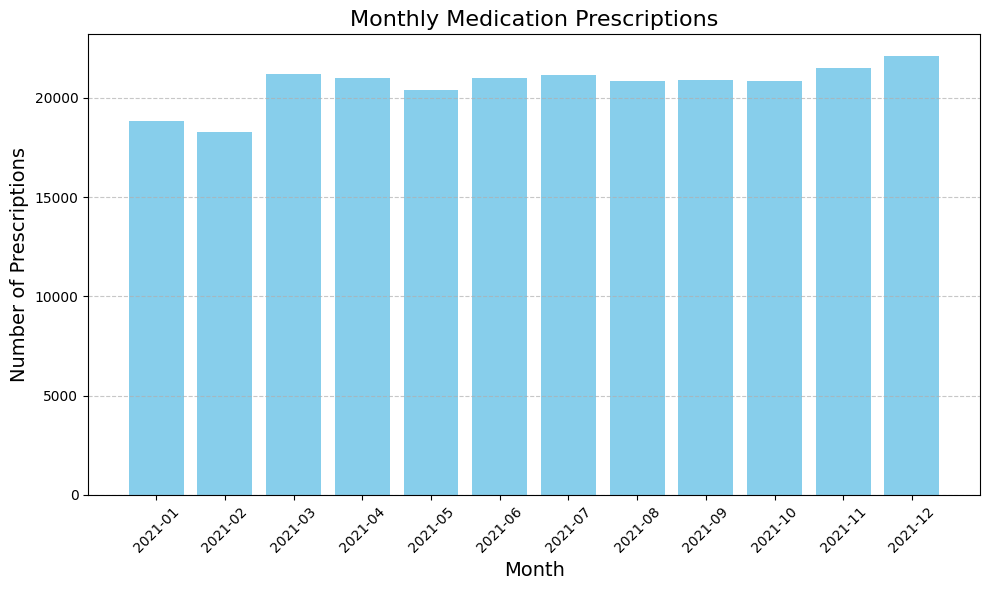

In [46]:
# 월별로 mi_code 처방 건수 집계
monthly_counts = df.groupby(df['RECU_FR_DT'].dt.to_period('M'))['pid'].count()

# 시각화를 위해 DataFrame으로 변환
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month', 'Prescriptions']

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_df['Month'].astype(str), monthly_counts_df['Prescriptions'], color='skyblue')
plt.title('Monthly Medication Prescriptions', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Prescriptions', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 월별 환자 수를 그래프로 확인하기

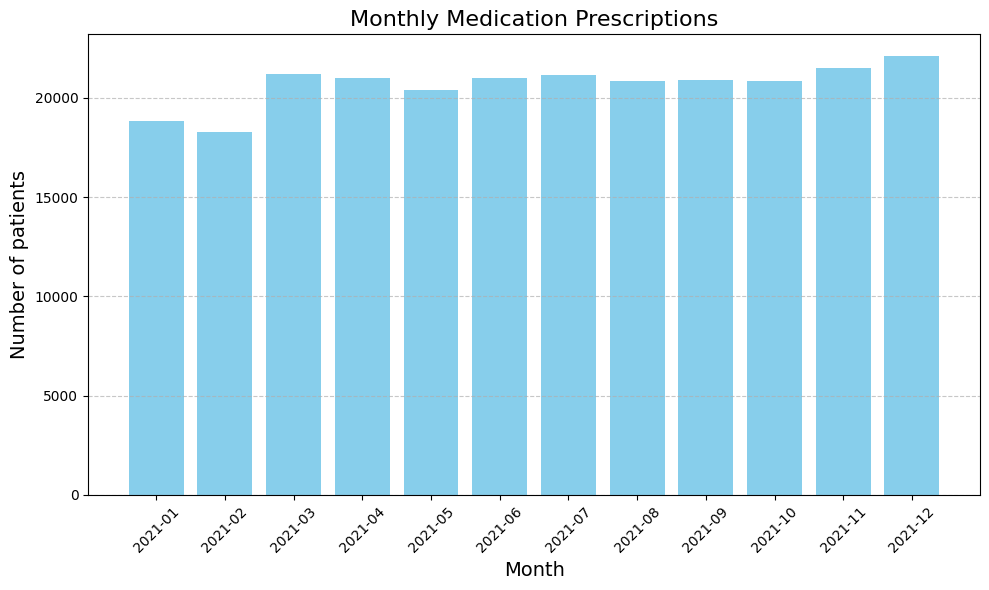

In [47]:
# 월별로 mi_code 처방 건수 집계
monthly_counts = df.groupby(df['RECU_FR_DT'].dt.to_period('M'))['uid'].count()

# 시각화를 위해 DataFrame으로 변환
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month', 'Prescriptions']

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_df['Month'].astype(str), monthly_counts_df['Prescriptions'], color='skyblue')
plt.title('Monthly Medication Prescriptions', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 월별 처방받은 약품의 개수 그래프로 확인하기

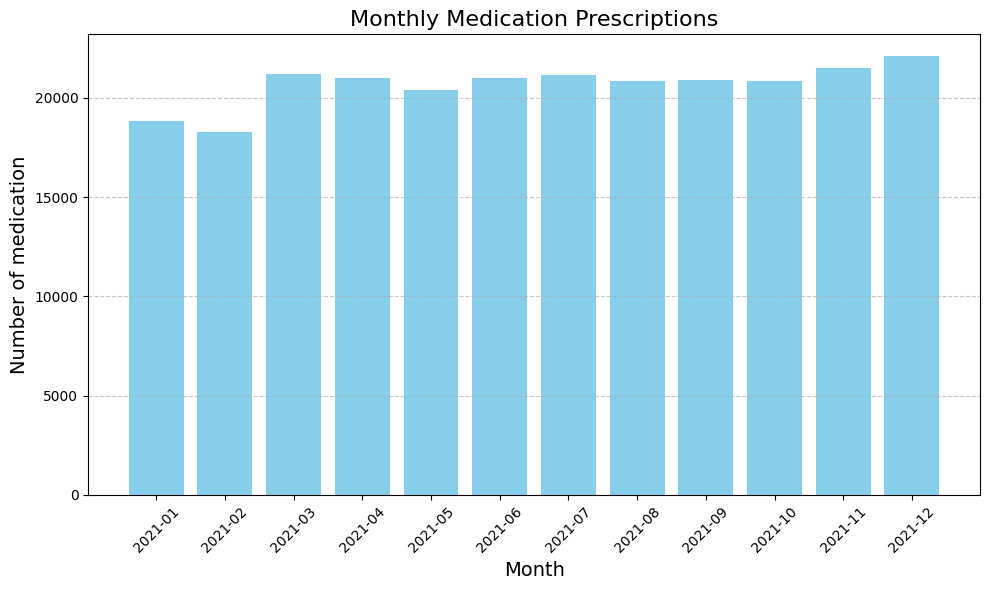

In [48]:
# 월별로 mi_code 처방 건수 집계
monthly_counts = df.groupby(df['RECU_FR_DT'].dt.to_period('M'))['mi_code'].count()

# 시각화를 위해 DataFrame으로 변환
monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month', 'Prescriptions']

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_df['Month'].astype(str), monthly_counts_df['Prescriptions'], color='skyblue')
plt.title('Monthly Medication Prescriptions', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of medication', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
# 월별 데이터프레임 생성
monthly_dataframes = {month: group for month, group in df.groupby(df['RECU_FR_DT'].dt.month)}

# 각 월별 데이터프레임을 변수로 저장
df_1 = monthly_dataframes.get(1)  # 1월 데이터
df_2 = monthly_dataframes.get(2)  # 2월 데이터
df_3 = monthly_dataframes.get(3)  # 3월 데이터
df_4 = monthly_dataframes.get(4)  # 3월 데이터
df_5 = monthly_dataframes.get(5)  # 3월 데이터
df_6 = monthly_dataframes.get(6)  # 3월 데이터
df_7 = monthly_dataframes.get(7)  # 3월 데이터
df_8 = monthly_dataframes.get(8)  # 3월 데이터
df_9 = monthly_dataframes.get(9)  # 3월 데이터
df_10 = monthly_dataframes.get(10)  # 3월 데이터
df_11 = monthly_dataframes.get(11)  # 3월 데이터
df_12 = monthly_dataframes.get(12)  # 3월 데이터

In [50]:
df_1.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드,주성분코드_5
1,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11,N06AX05,2429A
6,2021,22327,3839302,1,2,13,41,2021-01-28,428102ATR,1.0,1,30,522.0,15660,2022-08-11,N06AX12,4281A
20,2021,752039,3723883,1,2,13,41,2021-01-22,474802ATB,1.0,1,30,457.0,13710,2022-08-11,N06AB10,4748A
23,2021,262949,603663,1,2,13,41,2021-01-27,209302ATB,1.0,1,30,688.0,20640,2022-08-11,N06AB05,2093A
54,2021,454748,1916722,1,2,13,41,2021-01-28,242901ACH,1.0,1,7,40.0,280,2022-08-11,N06AX05,2429A


In [51]:
df_12.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT,ATC코드,주성분코드_5
18,2021,251575,3219521,1,2,13,41,2021-12-07,196204ATB,1.0,1,30,448.0,13440,2022-08-11,N06AX11,1962A
34,2021,426759,107399,1,2,13,41,2021-12-29,107501ATB,1.0,1,90,23.0,2070,2022-08-11,N06AA09,1075A
47,2021,743791,1460149,1,2,13,41,2021-12-23,474801ATB,1.0,1,7,402.0,2814,2022-08-11,N06AB10,4748A
51,2021,605483,1711537,1,2,13,41,2021-12-16,107504ATB,1.0,1,14,13.0,182,2022-08-11,N06AA09,1075A
57,2021,454748,2430440,1,2,13,41,2021-12-29,242901ACH,1.0,1,14,40.0,560,2022-08-11,N06AX05,2429A


In [66]:
# df_1부터 df_12까지 반복 처리 및 변수 생성
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12]

x_length = 0
for i, df in enumerate(dfs, 1):
    print(i, df.shape)
    x_length += df.shape[0]
    
print('2021 data length =', df.shape[0])

if x_length == int(df.shape[0]):
        print("Successfully divided")

total_data = 0        
for i in range(0,12):
        total_data += int(dfs[i].shape[0])
total_data

1 (18836, 17)
2 (18291, 17)
3 (21217, 17)
4 (21001, 17)
5 (20393, 17)
6 (21000, 17)
7 (21136, 17)
8 (20820, 17)
9 (20873, 17)
10 (20835, 17)
11 (21475, 17)
12 (22089, 17)
2021 data length = 22089


247966

### 노드는 약물, 엣지는 상호 처방 횟수, 노드 size는 centrality(어떤거?), 엣지 가중치는 상호처방횟수를 투명도로 설정

### 월별 Adjacency Matrix 생성하기

In [13]:
def process_patient_data(patient_groups):
    # 페어 카운트를 저장할 Counter 초기화
    pair_counts = Counter()

    for patient_id, group in patient_groups:
        # 해당 환자의 모든 처방 가져오기
        prescriptions = group.groupby('pid')['mi_code'].apply(list)

        # 해당 환자의 유니크 약물 주성분 페어와 자기 자신 루프를 저장할 집합
        patient_pairs = set()
        patient_self_loops = set()

        # 해당 환자에게 처방된 모든 유니크 약물 주성분 페어와 자기 자신 루프 수집
        for meds in prescriptions:
            # 처방 내 각 약물 주성분의 발생 횟수 계산
            med_counts = Counter(meds)

            # 한 번 이상 나타나는 약물 주성분 식별 (self-loop)
            for med, count in med_counts.items():
                if count > 1:
                    patient_self_loops.add(med)

            # 페어 조합을 위한 처방 내 유니크 약물 주성분 가져오기
            unique_meds_in_prescription = set(meds)
            pairs = combinations(unique_meds_in_prescription, 2)
            patient_pairs.update(pairs)

        # 해당 환자의 유니크 페어를 글로벌 페어 카운트에 업데이트
        pair_counts.update(patient_pairs)

        # 자기 자신 루프를 글로벌 페어 카운트에 업데이트
        for med in patient_self_loops:
            pair_counts[(med, med)] += 1

    return pair_counts

In [14]:
def build_adjacency_matrix(pair_counts, med_to_index):
    # 페어 카운트를 사용하여 인접 행렬 채우기
    adj_matrix = np.zeros((len(med_to_index), len(med_to_index)))

    for (med1, med2), count in pair_counts.items():
        idx1 = med_to_index[med1]
        idx2 = med_to_index[med2]
        adj_matrix[idx1][idx2] = count
        if med1 != med2:
            adj_matrix[idx2][idx1] = count  # 대칭 페어의 경우
        else:
            adj_matrix[idx1][idx2] = count  # 자기 자신 루프 (대각선 요소)

    return adj_matrix

In [15]:
def process_data_frame(df):
    # 고유한 약물 코드 인덱싱
    unique_meds = df["mi_code"].unique()
    med_to_index = {med: idx for idx, med in enumerate(unique_meds)}
    
    # 환자별 그룹화
    patient_groups = df.groupby('uid')
    
    # 페어 카운트 계산
    pair_counts = process_patient_data(patient_groups)
    
    # 인접 행렬 생성
    adj_matrix = build_adjacency_matrix(pair_counts, med_to_index)
    
    # 인접 행렬을 데이터 프레임으로 변환
    df_adjacency_matrix = pd.DataFrame(adj_matrix, index=unique_meds, columns=unique_meds)
    
    return df_adjacency_matrix

In [16]:
# df_1부터 df_12까지 반복 처리 및 변수 생성
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12]

for i, df in enumerate(dfs, 1):
    globals()[f'df_adjacency_matrix_{i}'] = process_data_frame(df)

In [17]:
globals()['df_adjacency_matrix_1']

,242901ACH,428102ATR,474802ATB,209302ATB,203401ATB,613101ATB,196204ATB,242901ATB,161502ACH,193201ACR,...,428103ATR,687701ATR,196202ATD,193202ACR,687702ATR,161501ATB,193202ATB,196204ATD,687602ATR,226401ATB
242901ACH,2.0,2.0,66.0,7.0,7.0,5.0,8.0,2.0,15.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
428102ATR,2.0,1.0,14.0,3.0,1.0,4.0,5.0,5.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474802ATB,66.0,14.0,14.0,5.0,21.0,13.0,1.0,122.0,17.0,1.0,...,2.0,1.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0
209302ATB,7.0,3.0,5.0,6.0,8.0,3.0,3.0,18.0,5.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
203401ATB,7.0,1.0,21.0,8.0,17.0,1.0,1.0,15.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
613101ATB,5.0,4.0,13.0,3.0,1.0,0.0,1.0,5.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
196204ATB,8.0,5.0,1.0,3.0,1.0,1.0,2.0,12.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242901ATB,2.0,5.0,122.0,18.0,15.0,5.0,12.0,5.0,22.0,0.0,...,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
161502ACH,15.0,7.0,17.0,5.0,2.0,1.0,3.0,22.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0
193201ACR,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
df_adjacency_matrix_1

,242901ACH,428102ATR,474802ATB,209302ATB,203401ATB,613101ATB,196204ATB,242901ATB,161502ACH,193201ACR,...,428103ATR,687701ATR,196202ATD,193202ACR,687702ATR,161501ATB,193202ATB,196204ATD,687602ATR,226401ATB
242901ACH,2.0,2.0,66.0,7.0,7.0,5.0,8.0,2.0,15.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
428102ATR,2.0,1.0,14.0,3.0,1.0,4.0,5.0,5.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474802ATB,66.0,14.0,14.0,5.0,21.0,13.0,1.0,122.0,17.0,1.0,...,2.0,1.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0
209302ATB,7.0,3.0,5.0,6.0,8.0,3.0,3.0,18.0,5.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
203401ATB,7.0,1.0,21.0,8.0,17.0,1.0,1.0,15.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
613101ATB,5.0,4.0,13.0,3.0,1.0,0.0,1.0,5.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
196204ATB,8.0,5.0,1.0,3.0,1.0,1.0,2.0,12.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242901ATB,2.0,5.0,122.0,18.0,15.0,5.0,12.0,5.0,22.0,0.0,...,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
161502ACH,15.0,7.0,17.0,5.0,2.0,1.0,3.0,22.0,6.0,2.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0
193201ACR,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
df_adjacency_matrix_12.iloc[:5, :5]

,196204ATB,107501ATB,474801ATB,107504ATB,242901ACH
196204ATB,2.0,8.0,20.0,1.0,1.0
107501ATB,8.0,20.0,14.0,9.0,18.0
474801ATB,20.0,14.0,8.0,8.0,31.0
107504ATB,1.0,9.0,8.0,10.0,6.0
242901ACH,1.0,18.0,31.0,6.0,2.0


### 월별 인접행렬을 시각화하기

In [24]:
# 주성분 매핑 데이터프레임을 불러옵니다.
df_mapping = pd.read_csv('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/anti_depressant_mapping.csv')

# 주성분 이름을 약자로 변환한 컬럼을 추가합니다.
df_mapping['주성분약자'] = df_mapping['주성분명'].apply(lambda x: x[:3])

# 주성분 코드를 주성분 이름으로 매핑하는 딕셔너리를 생성합니다.
mi_code_to_abbrev = df_mapping.set_index('주성분코드')['주성분약자'].to_dict()

In [25]:
def visualize_graph(df_adjacency_matrix, mi_code_to_abbrev, df_mapping, title="Graph Visualization"):
    # 그래프 생성
    G_coprescribed = nx.from_pandas_adjacency(df_adjacency_matrix)
    
    # 그래프 레이아웃 설정
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_coprescribed, seed=42, k=0.7)
    
    # 노드 크기 설정 (degree centrality 기반)
    node_size = [G_coprescribed.degree(node) * 3 for node in G_coprescribed.nodes]
    
    # 노드 색상 설정 (주성분 약자 기반)
    encode_abbrev = {abbrev: idx for idx, abbrev in enumerate(df_mapping['주성분약자'].unique())}
    node_color_by_abbrev = [encode_abbrev[mi_code_to_abbrev[node]] for node in G_coprescribed.nodes]
    nx.draw_networkx_nodes(G_coprescribed, pos, node_size=node_size, node_color=node_color_by_abbrev, cmap=plt.cm.tab20)
    
    # 엣지 투명도 설정 (weight에 비례)
    max_weight = max([d['weight'] for u, v, d in G_coprescribed.edges(data=True)])
    for edge in G_coprescribed.edges(data="weight"):
        nx.draw_networkx_edges(G_coprescribed, pos, edgelist=[edge], alpha=edge[2] / max_weight)
    
    # 노드 레이블 추가
    labels = {node: mi_code_to_abbrev[node] for node in G_coprescribed.nodes}
    nx.draw_networkx_labels(G_coprescribed, pos, labels, font_size=8)
    
    # 그래프 출력
    plt.title(title)
    plt.show()
    
    # 그래프 객체 반환
    return G_coprescribed

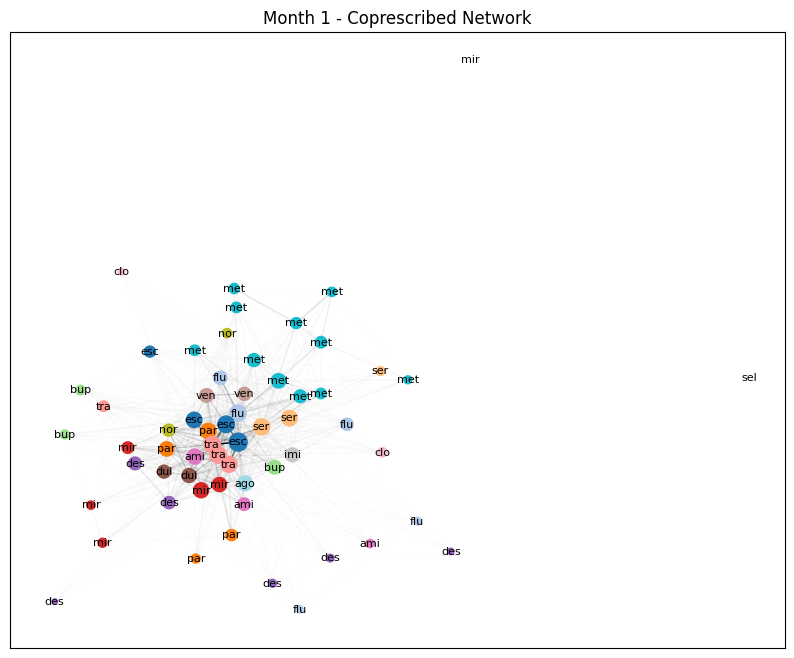

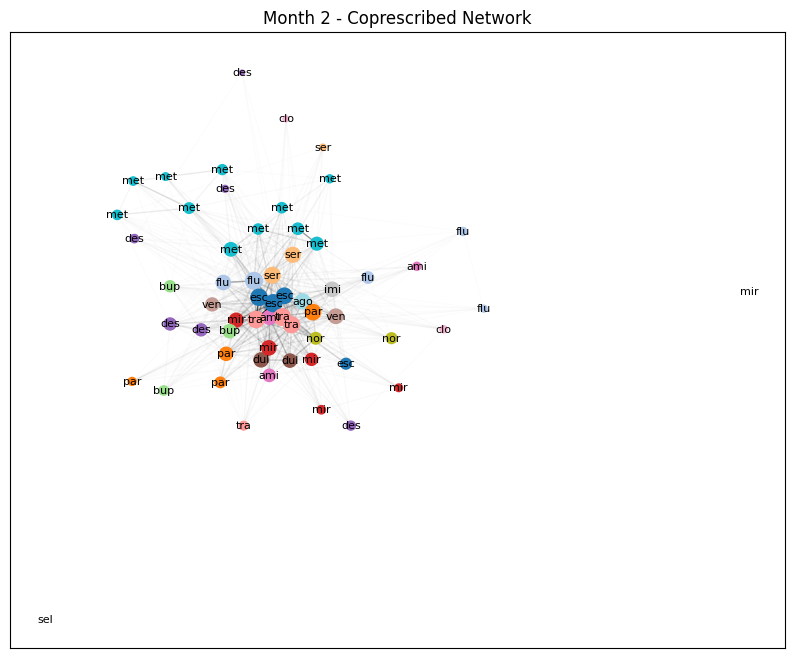

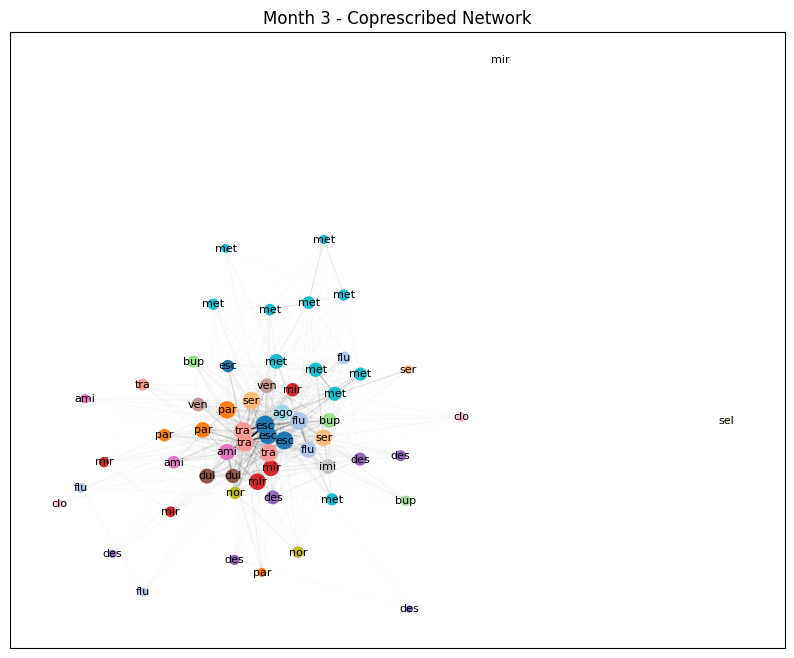

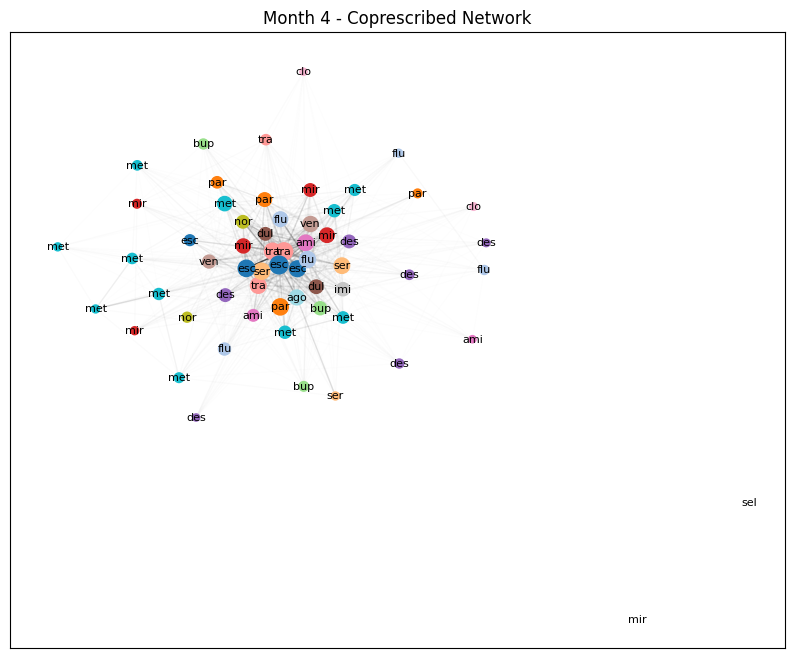

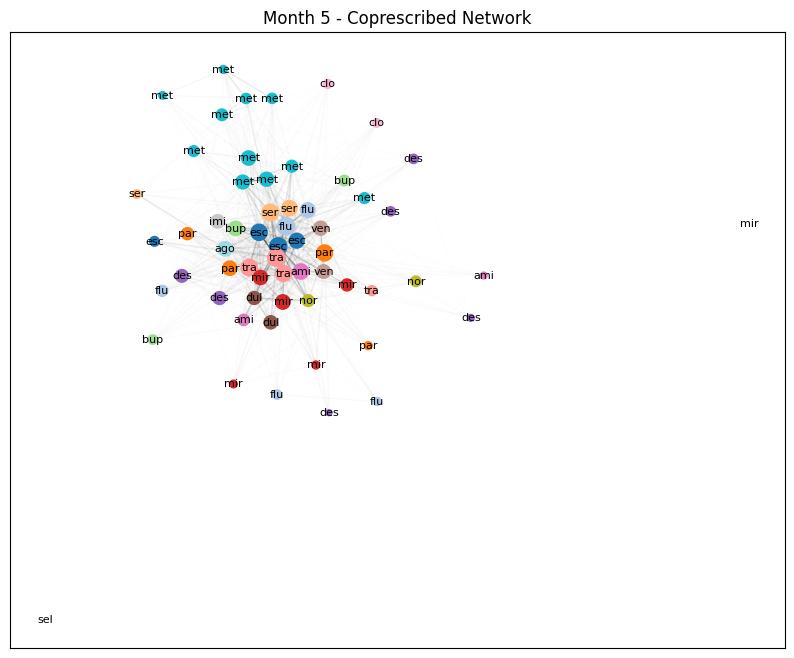

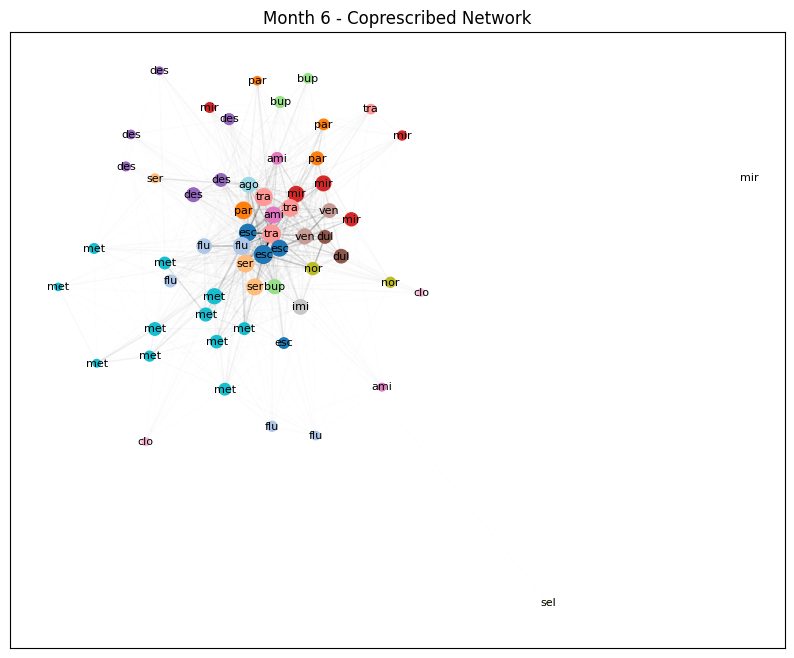

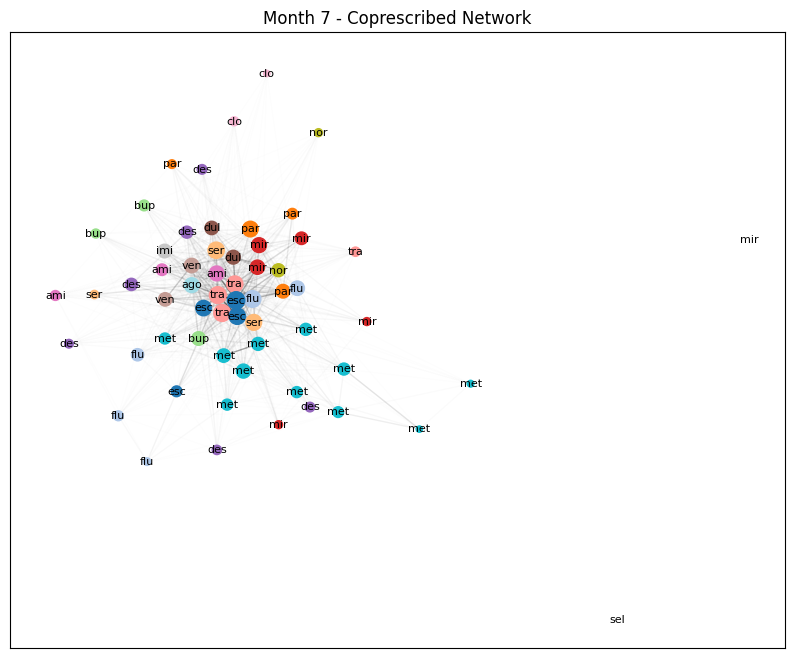

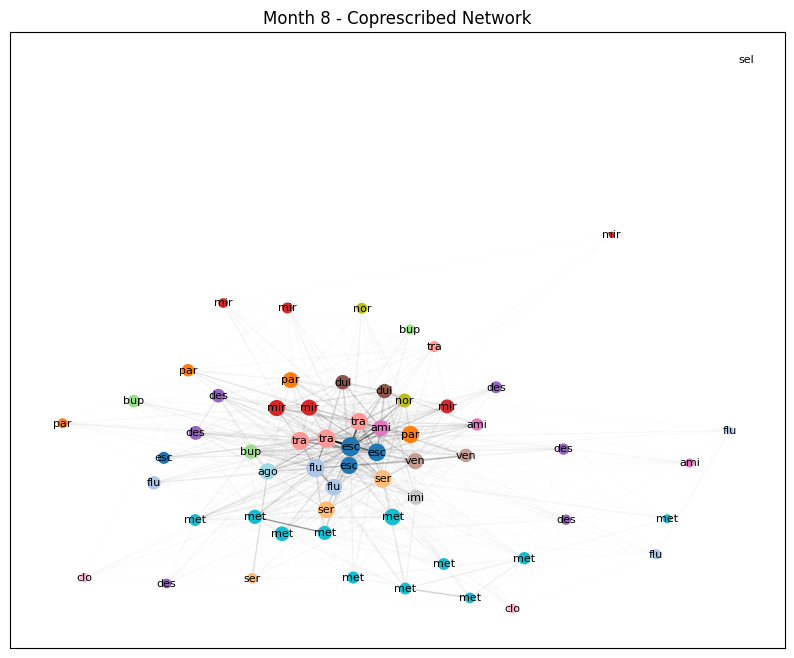

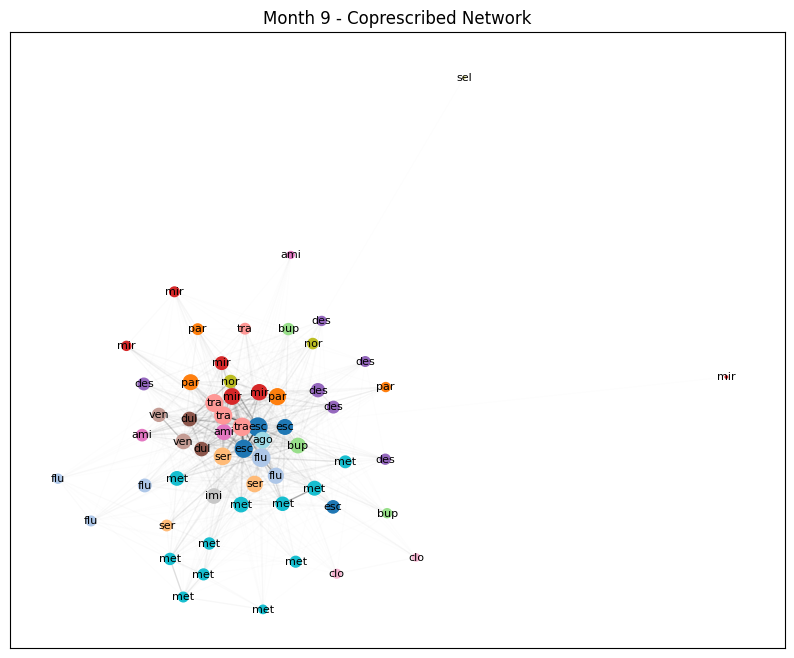

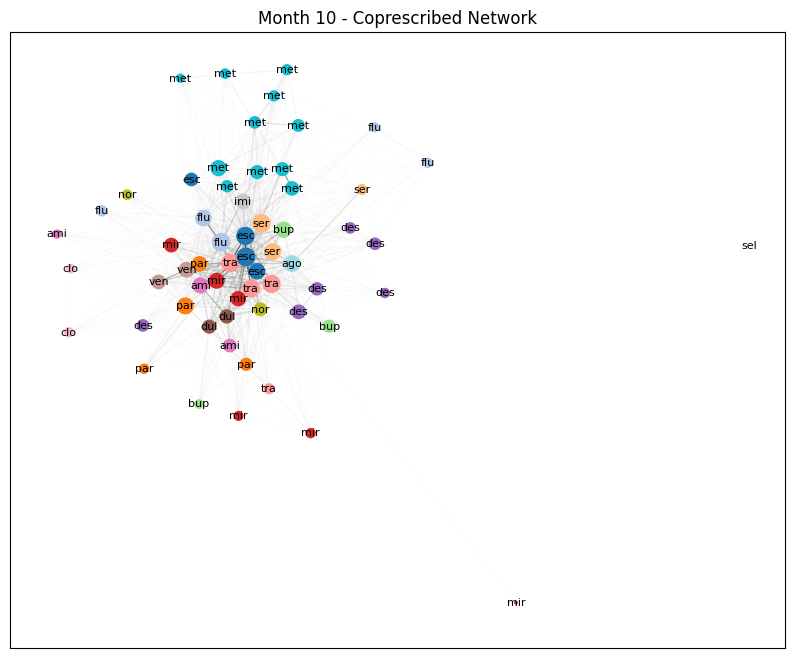

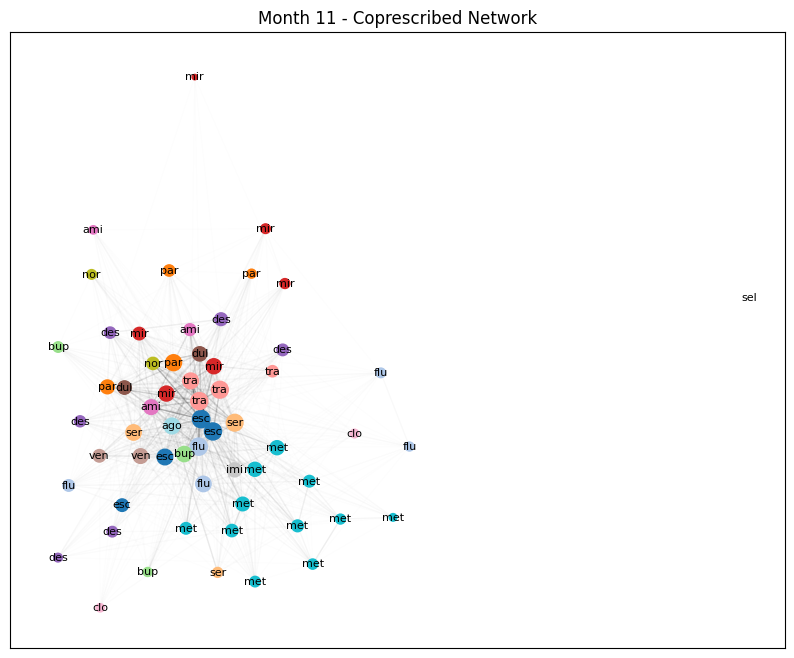

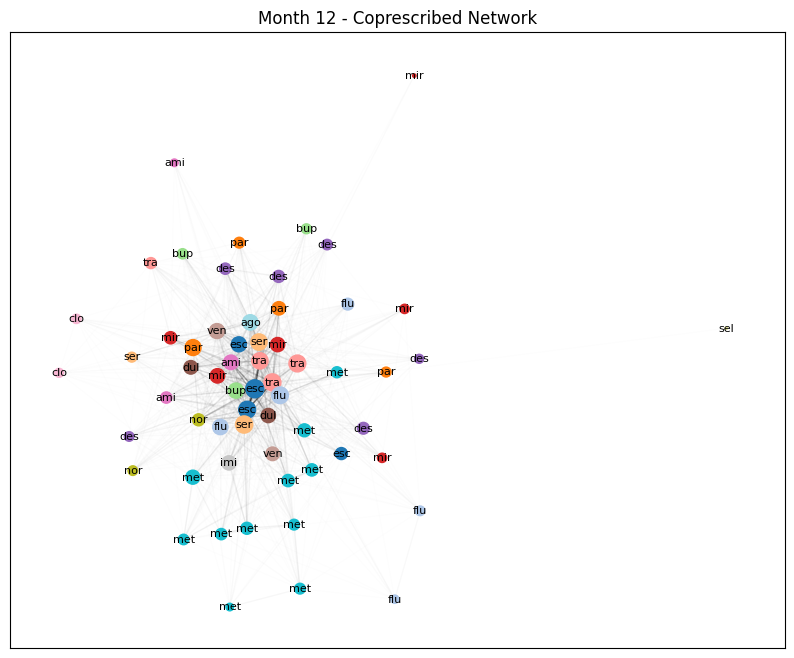

In [26]:
monthly_adjacency_matrices = [
                            df_adjacency_matrix_1, df_adjacency_matrix_2, df_adjacency_matrix_3, df_adjacency_matrix_4,
                            df_adjacency_matrix_5, df_adjacency_matrix_6, df_adjacency_matrix_7, df_adjacency_matrix_8,
                            df_adjacency_matrix_9, df_adjacency_matrix_10, df_adjacency_matrix_11, df_adjacency_matrix_12
                            ]

# 그래프를 저장할 딕셔너리 (선택 사항)
graphs = {}

# 월별 그래프 생성 및 변수에 저장
for i, df_adjacency_matrix in enumerate(monthly_adjacency_matrices, 1):
    title = f"Month {i} - Coprescribed Network"
    graph_variable_name = f"G_coprescribed_{i}"
    
    # 그래프 생성 및 반환
    G_coprescribed = visualize_graph(df_adjacency_matrix, mi_code_to_abbrev, df_mapping, title=title)
    
    # 전역 변수로 저장
    globals()[graph_variable_name] = G_coprescribed
    
    # 선택적으로 딕셔너리에 저장
    graphs[graph_variable_name] = G_coprescribed

In [27]:
len(G_coprescribed_1.nodes)

60

### Gephi로 시각화 위해 파일 저장

In [ ]:
# 그래프를 GraphML 형식으로 저장
for i in range(1, 13):  # 1월부터 12월까지
    graph_variable_name = f"G_coprescribed_{i}"
    G = globals()[graph_variable_name]  # 저장된 그래프 객체 불러오기
    nx.write_graphml(G, f"2021_coprescribed_graph_month_{i}.graphml")  # 파일로 저장

### 월별 네트워크의 변화 추이 보려면 
1) 노드 고정, 엣지 투명도+두께 변호 보기
        prob : 노드를 고정할 수 있나? + 특정 month에는 그 성분이 없거나 새롭게 추가되는 경우 반영 가능한가?

2) core집단의 변화 살피기에는 샘플 데이터가 적지 않나.(community, modularity 좀 더 공부해보기)

### 고유 노드 인덱스 매겨서 Gephi에서 노드 고정하기(모든 노드 고정해두고 특정 월에 처방되지 않았다면 투명하게 처리)

In [28]:
df = pd.read_csv('D:/소셜네트워크과학/Drug_Coprescription_Network_Analysis/data/2021_anti_depressant_final.csv')

In [29]:
df.head()

,STND_Y,uid,pid,SEQ_NO,SEX,AGE_GROUP,SIDO,RECU_FR_DT,mi_code,DD_MQTY_FREQ,DD_EXEC_FREQ,MDCN_EXEC_FREQ,UN_COST,AMT,DATA_STD_DT
0,2021,856296,1707917,1,2,13,41,2021-09-28,495501ACE,1.0,1,3,363.0,1089,2022-08-11
1,2021,454748,3323987,1,2,13,41,2021-01-25,242901ACH,1.0,1,3,40.0,120,2022-08-11
2,2021,251575,764386,1,2,13,41,2021-09-13,196204ATB,1.0,1,30,448.0,13440,2022-08-11
3,2021,235148,2654234,1,2,13,41,2021-10-13,107501ATB,1.0,1,30,23.0,690,2022-08-11
4,2021,524895,3529380,1,2,13,41,2021-10-01,209305ATR,1.0,1,30,729.0,21870,2022-08-11


In [30]:
df.shape

(234372, 15)

In [31]:
# 요양개시일자 형식을 datetime으로 변환
df['RECU_FR_DT'] = pd.to_datetime(df['RECU_FR_DT'])

### Gephi 로 불러들이는 데에 문제가 없게끔 전처리

In [32]:
def create_dynamic_gexf(monthly_dfs):
    G = nx.Graph()
    
    # 1. 노드 ID 표준화 및 시간 형식 수정
    for df in monthly_dfs.values():
        # mi_code를 문자열로 변환하고 공백 제거
        df['mi_code'] = df['mi_code'].astype(str).str.strip()
        # 날짜 형식 변환
        df['RECU_FR_DT'] = pd.to_datetime(df['RECU_FR_DT']).dt.strftime('%Y-%m-%dT00:00:00.000')
    
    # 2. 모든 고유 노드 추출
    all_nodes = set()
    for df in monthly_dfs.values():
        all_nodes.update(set(df['mi_code']))
    
    # 3. 노드 추가 (시간 속성 포함)
    for node in all_nodes:
        G.add_node(node, 
                  label=str(node),  # 라벨을 문자열로 확실히 변환
                  start='2021-01-01T00:00:00.000',  # 밀리초 단위 추가
                  end='2021-12-31T23:59:59.000')    # 밀리초 단위 추가
    
    # 4. 엣지 추가 (가중치 계산 및 시간 속성 포함)
    for month, df in monthly_dfs.items():
        # pid 기준으로 그룹화
        grouped = df.groupby('pid')
        
        for pid, group in grouped:
            # 같은 pid 내의 약품들 간 엣지 생성
            drugs = group['mi_code'].unique()
            for i in range(len(drugs)):
                for j in range(i + 1, len(drugs)):
                    source = str(drugs[i])  # 문자열로 변환
                    target = str(drugs[j])
                    
                    # 가중치 계산 (float으로 확실하게 변환)
                    weight = float(1.0)  # 또는 다른 가중치 계산 방식 사용
                    
                    # 시간 정보 가져오기
                    timestamp = group['RECU_FR_DT'].iloc[0]
                    
                    # 엣지 추가
                    if not G.has_edge(source, target):
                        G.add_edge(source, target, 
                                 weight=weight,
                                 start=timestamp,
                                 end='2021-12-31T23:59:59.000')
                    else:
                        # 기존 엣지의 가중치 업데이트
                        current_weight = G[source][target]['weight']
                        G[source][target]['weight'] = float(current_weight + weight)
                        
    # 4. Degree centrality 계산
    degree_centrality = nx.degree_centrality(G)
    
    # 5. 노드 크기 계산 및 노드 추가
    max_size = 100  # 최대 노드 크기
    min_size = 10   # 최소 노드 크기
    
    for node in all_nodes:
        size = min_size + (degree_centrality[node] * (max_size - min_size))
        G.add_node(node, 
                   label=str(node),
                   start='2021-01-01T00:00:00.000',
                   end='2021-12-31T23:59:59.000',
                   size=size)  # 노드 크기 추가
    
    # 5. GEXF 파일 저장
    nx.write_gexf(G, '2021_dynamic_drug_network(1).gexf', version='1.2draft')
    
    return G

# 실행
# monthly_dfs 딕셔너리 생성 (1월부터 12월까지의 데이터프레임)
monthly_dfs = {
    1: df_1,
    2: df_2,
    # ... 나머지 월 데이터
    12: df_12
}

G = create_dynamic_gexf(monthly_dfs)

# Part2 : 투여일수(30,60...)에 따른 엣지의 가중치를 설정하여 코로나 기간이 진행되면서 항우울제의 처방 정도가 심화되는지 분석

In [10]:
def create_dynamic_gexf(monthly_dfs):
    G = nx.Graph()
    
    # 1. 노드 ID 표준화 및 시간 형식 수정
    for df in monthly_dfs.values():
        df['mi_code'] = df['mi_code'].astype(str).str.strip()
        df['RECU_FR_DT'] = pd.to_datetime(df['RECU_FR_DT']).dt.strftime('%Y-%m-%dT00:00:00.000')
    
    # 2. 모든 고유 노드 추출
    all_nodes = set()
    for df in monthly_dfs.values():
        all_nodes.update(set(df['mi_code']))
    
    # 3. 노드 추가 (시간 속성 포함)
    for node in all_nodes:
        G.add_node(node, 
                   label=str(node),
                   start='2021-01-01T00:00:00.000',
                   end='2021-12-31T23:59:59.000')
    
    # 4. 엣지 추가 (가중치 계산 및 시간 속성 포함)
    for month, df in monthly_dfs.items():
        grouped = df.groupby('pid')
        
        for pid, group in grouped:
            drugs = group['mi_code'].unique()
            for i in range(len(drugs)):
                for j in range(i + 1, len(drugs)):
                    source = str(drugs[i])
                    target = str(drugs[j])
                    
                    # 투여일수에 따른 가중치 계산
                    days = group['MDCN_EXEC_FREQ'].max()  # 해당 그룹의 최대 투여일수
                    
                    # 14일 이하인 경우 가중치를 0으로 설정 (엣지 생성 안 함)
                    if days <= 14:
                        continue
                    
                    weight = (days - 14) // 30 + 1  # 14일 초과부터 30일마다 가중치 1씩 증가
                    
                    timestamp = group['RECU_FR_DT'].iloc[0]
                    
                    if not G.has_edge(source, target):
                        G.add_edge(source, target, 
                                   weight=weight,
                                   start=timestamp,
                                   end='2021-12-31T23:59:59.000')
                    else:
                        # 기존 엣지의 가중치 업데이트 (최대값 사용)
                        current_weight = G[source][target]['weight']
                        G[source][target]['weight'] = max(current_weight, weight)
    
    # 5. Degree centrality 계산 및 노드 크기 설정
    degree_centrality = nx.degree_centrality(G)
    max_size = 100
    min_size = 10
    for node in G.nodes():
        size = min_size + (degree_centrality[node] * (max_size - min_size))
        G.nodes[node]['viz'] = {'size': size}
    
    # 6. GEXF 파일 생성
    nx.write_gexf(G, "depression_network.gexf", version="1.2draft")
    
    return G

# 데이터프레임 딕셔너리 생성
monthly_dfs = {
    'Jan': df_1, 'Feb': df_2, 'Mar': df_3, 'Apr': df_4, 'May': df_5, 'Jun': df_6,
    'Jul': df_7, 'Aug': df_8, 'Sep': df_9, 'Oct': df_10, 'Nov': df_11, 'Dec': df_12
}

# 함수 실행
G = create_dynamic_gexf(monthly_dfs)

In [9]:
df['MDCN_EXEC_FREQ'].describe()

count    234372.000000
mean         29.451782
std          25.848292
min           1.000000
25%          14.000000
50%          28.000000
75%          30.000000
max         365.000000
Name: MDCN_EXEC_FREQ, dtype: float64